In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier, CatBoostRegressor
import optuna
from sklearn.model_selection import train_test_split

from library.Data_Preprocessing import Balance_Ratio
from library.Imbalance_Sampling import label_divide
from library.Aging_Score_Contour import score1
from library.AdaBoost import train_set, multiple_set, multiple_month, line_chart, cf_matrix, AUC, PR_curve, \
     multiple_curve, PR_matrix, best_threshold, all_optuna, optuna_history 

os.chdir('C:/Users/user/Desktop/Darui_R08621110') 
os.getcwd()

'C:\\Users\\user\\Desktop\\Darui_R08621110'

## 

### catboost

In [2]:
def CatBoostC(train_x, test_x, train_y, test_y, config, cat_feature):
    
    clf = CatBoostClassifier(**config, verbose = 0)
    clf.fit(train_x, train_y, cat_features = cat_feature)
    predict_y = clf.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})
    
    return result


def CatBoostR(train_x, test_x, train_y, test_y, config, cat_feature):
    
    reg = CatBoostRegressor(**config, verbose = 0)
    reg.fit(train_x, train_y, cat_features = cat_feature)
    predict_y = reg.predict(test_x)
    result = pd.DataFrame({'truth': test_y, 'predict': predict_y})

    return result


def runall_CatBoostC(num_set, trainset_x, test_x, trainset_y, test_y, config, cat_feature):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config
        
        result = CatBoostC(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config, cat_feature)
        table = cf_matrix(result, trainset_y[f'set{i}'])
        table_set = pd.concat([table_set, table]).rename(index = {0: f'dataset {i}'})

    return table_set
    
    
def runall_CatBoostR(num_set, trainset_x, test_x, trainset_y, test_y, config, cat_feature, thres_target = 'Recall', 
                     threshold = 0.8):
    
    table_set = pd.DataFrame()
    bad_set = pd.DataFrame()
    pr_dict = {}
    judge = list(config.keys())[0]

    for i in range(num_set):
        print('\n', f'Dataset {i}:')
        
        if isinstance(config[judge], dict) :
            best_config = config[f'set{i}']
        else :
            best_config = config

        predict = CatBoostR(trainset_x[f'set{i}'], test_x, trainset_y[f'set{i}'], test_y, best_config, cat_feature)
        pr_matrix = PR_matrix(predict, trainset_y[f'set{i}'])
        pr_dict[f'set{i}'] = pr_matrix
        
        best_data, best_thres = best_threshold(pr_matrix, target = thres_target, threshold = threshold)
        table_set = pd.concat([table_set, best_data]).rename(index = {best_data.index.values[0]: f'dataset {i}'})

    return pr_dict, table_set

### optuna

In [4]:
def CatBoost_creator(train_data, mode, cat_feature = [], num_valid = 3, label = 'GB') :

    def objective(trial) :
    
        param_1 = {
            'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
            'iterations': trial.suggest_int('iterations', 100, 300, step = 50),
            'depth': trial.suggest_int('depth', 2, 10, step = 2),
            'learning_rate': trial.suggest_float('learning_rate', 0.025, 0.325, step = 0.05),
            'subsample': trial.suggest_float('subsample', 0.5, 0.9, step = 0.2),
            'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10) 
        }

        if param_1['grow_policy'] == 'Depthwise' :
            param_2 = {
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 3, 30, step = 3)
            }
            param = {**param_1, **param_2}
        
        elif param_1['grow_policy'] == 'Lossguide' :
            param_3 = {
                'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 3, 30, step = 3),
                'max_leaves': trial.suggest_int('max_leaves', 15, 50, step = 5)
            }
            param = {**param_1, **param_3}
        
        else :
            param = param_1

        result_list = []
        for i in range(num_valid):

            train_good = train_data[train_data.GB == 0]
            train_bad = train_data[train_data.GB == 1]
            train_good_x, train_good_y = label_divide(train_good, None, label, train_only = True)
            train_bad_x, train_bad_y = label_divide(train_bad, None, label, train_only = True)
            train_g_x, valid_g_x, train_g_y, valid_g_y = train_test_split(train_good_x, train_good_y, test_size = 0.25)
            train_b_x, valid_b_x, train_b_y, valid_b_y = train_test_split(train_bad_x, train_bad_y, test_size = 0.25)
            train_x = pd.concat([train_g_x, train_b_x], axis = 0)
            train_y = pd.concat([train_g_y, train_b_y], axis = 0)
            valid_x = pd.concat([valid_g_x, valid_b_x], axis = 0)
            valid_y = pd.concat([valid_g_y, valid_b_y], axis = 0)

            if mode == 'C':
                result = CatBoostC(train_x, valid_x, train_y, valid_y, param, cat_feature)
                table = cf_matrix(result, valid_y)
                recall = table['Recall']
                aging = table['Aging Rate']
                effi = table['Efficiency']
                result_list.append(recall - 0.5*aging)

            elif mode == 'R':
                result = CatBoostR(train_x, valid_x, train_y, valid_y, param, cat_feature)
                pr_matrix = PR_matrix(result, valid_y)
                auc = AUC(pr_matrix['Recall'], pr_matrix['Aging Rate'])
                result_list.append((-1)*auc)

        return np.mean(result_list)

    return objective

## 

### loading training & testing data

In [5]:
### training data ### 
training_month = range(1, 7)

data_dict, trainset_x, trainset_y = multiple_month(training_month, num_set = 10, filename = 'dataset')

print('\nCombined training data:\n')
run_train = multiple_set(num_set = 10)
run_train_x, run_train_y = train_set(run_train, num_set = 10)

### testing data ###
run_test = pd.read_csv('test_runhist.csv').iloc[:, 2:]
run_test_x, run_test_y = label_divide(run_test, None, 'GB', train_only = True)
print('\n', 'Dimension of testing data:', run_test.shape)


Month 1:

Dimension of dataset 0 : (17735, 84)  balance ratio: 1181.0
Dimension of dataset 1 : (296, 84)  balance ratio: 1.0
Dimension of dataset 2 : (420, 84)  balance ratio: 1.0
Dimension of dataset 3 : (328, 84)  balance ratio: 1.0
Dimension of dataset 4 : (300, 84)  balance ratio: 1.0
Dimension of dataset 5 : (298, 84)  balance ratio: 1.0
Dimension of dataset 6 : (370, 84)  balance ratio: 1.0
Dimension of dataset 7 : (300, 84)  balance ratio: 1.0
Dimension of dataset 8 : (300, 84)  balance ratio: 1.0
Dimension of dataset 9 : (165, 84)  balance ratio: 10.0

 10 datasets are loaded.

Labels of  10 datasets are divided.

Month 2:

Dimension of dataset 0 : (39009, 90)  balance ratio: 533.0
Dimension of dataset 1 : (1460, 90)  balance ratio: 1.0
Dimension of dataset 2 : (1908, 90)  balance ratio: 1.0
Dimension of dataset 3 : (1604, 90)  balance ratio: 1.0
Dimension of dataset 4 : (1460, 90)  balance ratio: 1.0
Dimension of dataset 5 : (1465, 90)  balance ratio: 1.0
Dimension of dataset

### search for best hyperparameter

In [5]:
best_paramC, all_scoreC = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'C', 
                                     TPE_multi = True, 
                                     n_iter = 200, 
                                     filename = 'runhist_array_m1m6_m7_3criteria_CatBoost', 
                                     creator = CatBoost_creator
                                    )

  0%|          | 0/10 [00:00<?, ?it/s]

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 14:17:12,229] A new study created in memory with name: no-name-668dd61b-1b30-48b7-a0ee-81b90b9443dc


Dataset0 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9142857142857143 
Recall: 0.29906542056074764 
Aging Rate: 0.0006052117376493576
Precision: 0.8055555555555556 
Recall: 0.25 
Aging Rate: 0.0006225035015821964
Precision: 0.9393939393939394 
Recall: 0.256198347107438 
Aging Rate: 0.00057062820978368
[I 2021-11-19 14:17:44,657] Trial 0 finished with value: 0.268121531981226 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 1.8620862449770346, 'min_data_in_leaf': 3, 'max_leaves': 20}. Best is trial 0 with value: 0.268121531981226.
Precision: 1.0 
Recall: 0.021897810218978103 
Aging Rate: 5.187529179851637e-05
Precision: 0.0 
Recall: 0.0 
Aging Rate: 1.729176393283879e-05
Precision: 0.6666666666666666 
Recall: 0.031496062992125984 
Aging Rate: 0.00010375058359703273
[I 2021-11-19 14:18:05,595] Trial 1 finished with value: 0.017769138130479964 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 2, 'learning_rate': 0.325, 'su

Training has stopped (degenerate solution on iteration 66, probably too small l2-regularization, try to increase it)


Precision: 0.900990099009901 
Recall: 0.6546762589928058 
Aging Rate: 0.0017464681572167177


Training has stopped (degenerate solution on iteration 138, probably too small l2-regularization, try to increase it)


Precision: 0.8461538461538461 
Recall: 0.7795275590551181 
Aging Rate: 0.0020231363801421383
Precision: 0.816 
Recall: 0.7906976744186046 
Aging Rate: 0.002161470491604849
[I 2021-11-19 14:19:14,966] Trial 3 finished with value: 0.7406453183173488 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0025540325130706453, 'min_data_in_leaf': 30}. Best is trial 3 with value: 0.7406453183173488.
Precision: 0.8888888888888888 
Recall: 0.14814814814814814 
Aging Rate: 0.0003112517507910982
Precision: 1.0 
Recall: 0.16923076923076924 
Aging Rate: 0.00038041880652245336
Precision: 1.0 
Recall: 0.11904761904761904 
Aging Rate: 0.0002593764589925818
[I 2021-11-19 14:19:51,660] Trial 4 finished with value: 0.1453170043061278 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.803516200005705}. Best is trial 3 with 

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.5 
Recall: 0.009174311926605505 
Aging Rate: 3.458352786567758e-05
Precision: 0.6666666666666666 
Recall: 0.015625 
Aging Rate: 5.187529179851637e-05
[I 2021-11-19 14:20:18,788] Trial 5 finished with value: 0.008252027505591135 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 7.939243481896327, 'min_data_in_leaf': 24}. Best is trial 3 with value: 0.7406453183173488.
Precision: 0.8985507246376812 
Recall: 0.5585585585585585 
Aging Rate: 0.0011931317113658764
Precision: 0.9130434782608695 
Recall: 0.5080645161290323 
Aging Rate: 0.0011931317113658764
Precision: 0.8169014084507042 
Recall: 0.5523809523809524 
Aging Rate: 0.001227715239231554
[I 2021-11-19 14:20:47,264] Trial 6 finished with value: 0.5390656792458539 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 1.8

Training has stopped (degenerate solution on iteration 57, probably too small l2-regularization, try to increase it)


Precision: 1.0 
Recall: 0.02654867256637168 
Aging Rate: 5.187529179851637e-05


Training has stopped (degenerate solution on iteration 48, probably too small l2-regularization, try to increase it)


Precision: 0.3333333333333333 
Recall: 0.018691588785046728 
Aging Rate: 0.00010375058359703273


Training has stopped (degenerate solution on iteration 17, probably too small l2-regularization, try to increase it)


Precision: 1.0 
Recall: 0.00847457627118644 
Aging Rate: 1.729176393283879e-05
[I 2021-11-19 14:20:53,771] Trial 7 finished with value: 0.017876126267646886 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0011164983973751311, 'min_data_in_leaf': 6}. Best is trial 3 with value: 0.7406453183173488.
Precision: 0.9310344827586207 
Recall: 0.7168141592920354 
Aging Rate: 0.0015043834621569746
Precision: 0.9285714285714286 
Recall: 0.7155963302752294 
Aging Rate: 0.0014525081703584582
Precision: 0.9148936170212766 
Recall: 0.7049180327868853 
Aging Rate: 0.0016254258096868462
[I 2021-11-19 14:21:46,211] Trial 8 finished with value: 0.7116791212110164 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.07313773927585404, 'min_data_in_leaf': 18, 'max_leaves': 50}. Best is trial 3 with value: 0.7406453183173488.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.009615384615384616 
Aging Rate: 1.729176393283879e-05
[I 2021-11-19 14:22:14,360] Trial 9 finished with value: 0.003202246244472732 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 6.577535195641053}. Best is trial 3 with value: 0.7406453183173488.
Precision: 0.853448275862069 
Recall: 0.792 
Aging Rate: 0.0020058446162092994
Precision: 0.839622641509434 
Recall: 0.7807017543859649 
Aging Rate: 0.0018329269768809116
Precision: 0.941747572815534 
Recall: 0.782258064516129 
Aging Rate: 0.0017810516850823952
[I 2021-11-19 14:23:01,815] Trial 10 finished with value: 0.7840499690876692 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.01749468614176333, 'min_data_in_leaf': 30}. Best is trial 10 with value: 0.7840499690876692.
Precision: 0.

Training has stopped (degenerate solution on iteration 24, probably too small l2-regularization, try to increase it)


Precision: 0.3225806451612903 
Recall: 0.09009009009009009 
Aging Rate: 0.0005360446819180025


Training has stopped (degenerate solution on iteration 104, probably too small l2-regularization, try to increase it)


Precision: 0.6043956043956044 
Recall: 0.39568345323741005 
Aging Rate: 0.0015735505178883298


Training has stopped (degenerate solution on iteration 22, probably too small l2-regularization, try to increase it)


Precision: 0.06338028169014084 
Recall: 0.0661764705882353 
Aging Rate: 0.002455430478463108
[I 2021-11-19 14:31:42,546] Trial 19 finished with value: 0.18322250035886692 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.001596477128904938, 'min_data_in_leaf': 15}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.9444444444444444 
Recall: 0.1619047619047619 
Aging Rate: 0.0003112517507910982
Precision: 0.9583333333333334 
Recall: 0.17692307692307693 
Aging Rate: 0.00041500233438813094
Precision: 0.6666666666666666 
Recall: 0.14035087719298245 
Aging Rate: 0.00041500233438813094
[I 2021-11-19 14:33:31,694] Trial 20 finished with value: 0.15953602927034585 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.03037188570842386, 'min_data_in_leaf': 12}. Best is trial 12 with value: 0.8243515761793422.
Precision:

Training has stopped (degenerate solution on iteration 84, probably too small l2-regularization, try to increase it)


Precision: 0.8181818181818182 
Recall: 0.1651376146788991 
Aging Rate: 0.00038041880652245336
Precision: 0.8118811881188119 
Recall: 0.6890756302521008 
Aging Rate: 0.0017464681572167177
[I 2021-11-19 14:42:44,952] Trial 28 finished with value: 0.5557864627936193 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.0018913205015511064, 'min_data_in_leaf': 27, 'max_leaves': 40}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.6666666666666666 
Recall: 0.030534351145038167 
Aging Rate: 0.00010375058359703273
Precision: 0.8333333333333334 
Recall: 0.03571428571428571 
Aging Rate: 0.00010375058359703273
Precision: 0.8571428571428571 
Recall: 0.05309734513274336 
Aging Rate: 0.00012104234752987152
[I 2021-11-19 14:43:21,621] Trial 29 finished with value: 0.03972723674490176 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 4, 'learning_rate': 0.07500000000000001, 'subsa

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-19 14:55:29,472] Trial 40 finished with value: 0.0 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.09374235365812891, 'min_data_in_leaf': 27, 'max_leaves': 25}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.8411214953271028 
Recall: 0.8571428571428571 
Aging Rate: 0.0018502187408137504
Precision: 0.856 
Recall: 0.7588652482269503 
Aging Rate: 0.002161470491604849
Precision: 0.926605504587156 
Recall: 0.7214285714285714 
Aging Rate: 0.001884802268679428
[I 2021-11-19 14:56:44,247] Trial 41 finished with value: 0.7781628103492766 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.016646641121375073, 'min_data_in_leaf': 21, 'max_leaves': 35}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.8913043478260869 
Recall: 0.706896

Training has stopped (degenerate solution on iteration 53, probably too small l2-regularization, try to increase it)


Precision: 0.5652173913043478 
Recall: 0.11206896551724138 
Aging Rate: 0.0003977105704552921


Training has stopped (degenerate solution on iteration 29, probably too small l2-regularization, try to increase it)


Precision: 0.35714285714285715 
Recall: 0.08196721311475409 
Aging Rate: 0.0004841693901194861


Training has stopped (degenerate solution on iteration 18, probably too small l2-regularization, try to increase it)


Precision: 0.4444444444444444 
Recall: 0.064 
Aging Rate: 0.0003112517507910982
[I 2021-11-19 15:08:08,790] Trial 50 finished with value: 0.08581320425877086 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.0025196636199746334, 'min_data_in_leaf': 9, 'max_leaves': 25}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.8938053097345132 
Recall: 0.753731343283582 
Aging Rate: 0.0019539693244107832
Precision: 0.9157894736842105 
Recall: 0.725 
Aging Rate: 0.0016427175736196849
Precision: 0.8275862068965517 
Recall: 0.732824427480916 
Aging Rate: 0.0020058446162092994
[I 2021-11-19 15:10:11,154] Trial 51 finished with value: 0.736251501669126 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.06833431355860785, 'min_data_in_leaf': 18}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.9009900990099

Training has stopped (degenerate solution on iteration 240, probably too small l2-regularization, try to increase it)


Precision: 0.8469387755102041 
Recall: 0.7685185185185185 
Aging Rate: 0.0016945928654182013


Training has stopped (degenerate solution on iteration 229, probably too small l2-regularization, try to increase it)


Precision: 0.7711864406779662 
Recall: 0.7647058823529411 
Aging Rate: 0.002040428144074977


Training has stopped (degenerate solution on iteration 21, probably too small l2-regularization, try to increase it)


Precision: 0.2222222222222222 
Recall: 0.04477611940298507 
Aging Rate: 0.0004668776261866473
[I 2021-11-19 15:20:54,179] Trial 59 finished with value: 0.5252998569855349 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.0032135470237631223, 'min_data_in_leaf': 15}. Best is trial 12 with value: 0.8243515761793422.


Training has stopped (degenerate solution on iteration 79, probably too small l2-regularization, try to increase it)


Precision: 0.038461538461538464 
Recall: 0.009900990099009901 
Aging Rate: 0.0004495858622538085


Training has stopped (degenerate solution on iteration 64, probably too small l2-regularization, try to increase it)


Precision: 0.3333333333333333 
Recall: 0.008620689655172414 
Aging Rate: 5.187529179851637e-05


Training has stopped (degenerate solution on iteration 85, probably too small l2-regularization, try to increase it)


Precision: 0.09090909090909091 
Recall: 0.008928571428571428 
Aging Rate: 0.00019020940326122668
[I 2021-11-19 15:21:13,234] Trial 60 finished with value: 0.009034805301365656 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0015023854435826565, 'min_data_in_leaf': 18}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.7058823529411765 
Recall: 0.4 
Aging Rate: 0.0011758399474330375


Training has stopped (degenerate solution on iteration 15, probably too small l2-regularization, try to increase it)
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


Training has stopped (degenerate solution on iteration 54, probably too small l2-regularization, try to increase it)


Precision: 0.42857142857142855 
Recall: 0.05084745762711865 
Aging Rate: 0.00024208469505974305
[I 2021-11-19 15:21:36,564] Trial 61 finished with value: 0.15004616510195742 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.0018509354931350276}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.8839285714285714 
Recall: 0.8048780487804879 
Aging Rate: 0.0019366775604779444
Precision: 0.9615384615384616 
Recall: 0.6637168141592921 
Aging Rate: 0.0013487575867614256
Precision: 0.9489795918367347 
Recall: 0.75 
Aging Rate: 0.0016945928654182013
[I 2021-11-19 15:22:33,007] Trial 62 finished with value: 0.7387016163111504 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.0032420686027311877}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.7946428571428571 
Reca

Training has stopped (degenerate solution on iteration 196, probably too small l2-regularization, try to increase it)


Precision: 0.8378378378378378 
Recall: 0.8303571428571429 
Aging Rate: 0.0019193857965451055


Training has stopped (degenerate solution on iteration 9, probably too small l2-regularization, try to increase it)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.0002766682229254206


Training has stopped (degenerate solution on iteration 74, probably too small l2-regularization, try to increase it)


Precision: 0.8295454545454546 
Recall: 0.584 
Aging Rate: 0.0015216752260898134
[I 2021-11-19 15:31:16,848] Trial 68 finished with value: 0.47083275941145425 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0012148214273468008, 'min_data_in_leaf': 27}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.8571428571428571 
Recall: 0.7552447552447552 
Aging Rate: 0.0021787622555376873
Precision: 0.8727272727272727 
Recall: 0.7804878048780488 
Aging Rate: 0.0019020940326122668
Precision: 0.9519230769230769 
Recall: 0.7795275590551181 
Aging Rate: 0.001798343449015234
[I 2021-11-19 15:32:47,832] Trial 69 finished with value: 0.7707735064364466 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.05236253647223539, 'min_data_in_leaf': 21}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.8780487804878049

Training has stopped (degenerate solution on iteration 48, probably too small l2-regularization, try to increase it)


Precision: 0.1 
Recall: 0.017094017094017096 
Aging Rate: 0.0003458352786567758


Training has stopped (degenerate solution on iteration 22, probably too small l2-regularization, try to increase it)


Precision: 0.2 
Recall: 0.015151515151515152 
Aging Rate: 0.0001729176393283879
[I 2021-11-19 15:33:18,491] Trial 70 finished with value: 0.22664194737131396 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.002607112025686388, 'min_data_in_leaf': 24, 'max_leaves': 45}. Best is trial 12 with value: 0.8243515761793422.
Precision: 1.0 
Recall: 0.018691588785046728 
Aging Rate: 3.458352786567758e-05
Precision: 1.0 
Recall: 0.008403361344537815 
Aging Rate: 1.729176393283879e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-19 15:33:31,001] Trial 71 finished with value: 0.009023004161228428 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.12584349990885704, 'min_data_in_leaf': 21}. Best is trial 12 with value: 0.8243515761793422.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-19 15:33:52,946] Trial 72 finished with value: 0.0 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 4.524764585315611, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.6666666666666666 
Recall: 0.01818181818181818 
Aging Rate: 5.187529179851637e-05
Precision: 0.6666666666666666 
Recall: 0.032 
Aging Rate: 0.00010375058359703273
Precision: 1.0 
Recall: 0.056074766355140186 
Aging Rate: 0.00010375058359703273
[I 2021-11-19 15:34:49,480] Trial 73 finished with value: 0.03537563210248736 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.028356359719177035}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.883495145631068 
Recall: 0.7338709677419355 
Aging Rate: 0.0017810516850823952
Precision: 0.91

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-19 15:43:49,419] Trial 80 finished with value: 0.0 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.0016939182669350316, 'min_data_in_leaf': 18}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.8879310344827587 
Recall: 0.7573529411764706 
Aging Rate: 0.0020058446162092994
Precision: 0.9142857142857143 
Recall: 0.8067226890756303 
Aging Rate: 0.001815635212948073
Precision: 0.8738738738738738 
Recall: 0.7578125 
Aging Rate: 0.0019193857965451055
[I 2021-11-19 15:45:12,658] Trial 81 finished with value: 0.7730058991464165 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.8317162407742671, 'min_data_in_leaf': 18}. Best is trial 12 with value: 0.8243515761793422.
Precision: 1.0 
Recall: 0.00980392156862745 
Aging Rate: 1.72917

C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-19 15:45:37,639] Trial 82 finished with value: 0.006108330823245581 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.20220507603597132, 'min_data_in_leaf': 12}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.8640776699029126 
Recall: 0.8018018018018018 
Aging Rate: 0.0017810516850823952
Precision: 0.8942307692307693 
Recall: 0.7380952380952381 
Aging Rate: 0.001798343449015234
Precision: 0.8333333333333334 
Recall: 0.6944444444444444 
Aging Rate: 0.001556258753955491
[I 2021-11-19 15:47:14,479] Trial 83 finished with value: 0.7439245524658192 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.11915990765674035, 'min_data_in_leaf': 18}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.7874015748031497 
Recall: 0.7874015748031497 
Aging Rat

Training has stopped (degenerate solution on iteration 201, probably too small l2-regularization, try to increase it)


Precision: 0.853448275862069 
Recall: 0.8048780487804879 
Aging Rate: 0.0020058446162092994
Precision: 0.8482142857142857 
Recall: 0.7723577235772358 
Aging Rate: 0.0019366775604779444
[I 2021-11-19 15:48:27,860] Trial 84 finished with value: 0.7871893530209316 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.00812766102277072, 'min_data_in_leaf': 15}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.75 
Recall: 0.022222222222222223 
Aging Rate: 6.916705573135516e-05


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 0.5 
Recall: 0.008771929824561403 
Aging Rate: 3.458352786567758e-05
[I 2021-11-19 15:48:54,460] Trial 85 finished with value: 0.010314092251661704 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 8.716148169696872}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.8839285714285714 
Recall: 0.7983870967741935 
Aging Rate: 0.0019366775604779444
Precision: 0.9056603773584906 
Recall: 0.8 
Aging Rate: 0.0018329269768809116
Precision: 0.8952380952380953 
Recall: 0.7899159663865546 
Aging Rate: 0.001815635212948073
[I 2021-11-19 15:50:00,691] Trial 86 finished with value: 0.795170147761865 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.01812555910228314, 'min_data_in_leaf': 21, 'max_leaves': 45}. Best is trial 12 with value: 0.82435157617

Training has stopped (degenerate solution on iteration 24, probably too small l2-regularization, try to increase it)


Precision: 0.26666666666666666 
Recall: 0.028169014084507043 
Aging Rate: 0.0002593764589925818


Training has stopped (degenerate solution on iteration 17, probably too small l2-regularization, try to increase it)
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
[I 2021-11-19 15:56:00,713] Trial 91 finished with value: 0.23227258932912365 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.007692862365062357, 'min_data_in_leaf': 21, 'max_leaves': 30}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.8737864077669902 
Recall: 0.8411214953271028 
Aging Rate: 0.0017810516850823952
Precision: 0.8898305084745762 
Recall: 0.8267716535433071 
Aging Rate: 0.002040428144074977
Precision: 0.868421052631579 
Recall: 0.792 
Aging Rate: 0.001971261088343622
[I 2021-11-19 15:56:43,691] Trial 92 finished with value: 0.8189989261372198 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.19527308447984357, 'min_data_in_leaf': 24, 'max_leaves': 35}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.9083333333333333 


Precision: 0.9166666666666666 
Recall: 0.7857142857142857 
Aging Rate: 0.0016600093375525237
Precision: 0.8829787234042553 
Recall: 0.7345132743362832 
Aging Rate: 0.0016254258096868462
[I 2021-11-19 16:07:54,336] Trial 105 finished with value: 0.7656772220954217 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.09441353871331573, 'min_data_in_leaf': 24}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.9150943396226415 
Recall: 0.751937984496124 
Aging Rate: 0.0018329269768809116
Precision: 0.8617886178861789 
Recall: 0.803030303030303 
Aging Rate: 0.002126886963739171
Precision: 0.9292929292929293 
Recall: 0.7931034482758621 
Aging Rate: 0.0017118846293510401
[I 2021-11-19 16:08:49,113] Trial 106 finished with value: 0.7817452955057678 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.20032746035058457,

Training has stopped (degenerate solution on iteration 25, probably too small l2-regularization, try to increase it)


Precision: 0.0 
Recall: 0.0 
Aging Rate: 5.187529179851637e-05
Precision: 0.6571428571428571 
Recall: 0.20909090909090908 
Aging Rate: 0.0006052117376493576
Precision: 0.7619047619047619 
Recall: 0.27586206896551724 
Aging Rate: 0.0007262540851792291
[I 2021-11-19 16:12:42,463] Trial 110 finished with value: 0.16142043583303758 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.0029724487039635584, 'min_data_in_leaf': 18}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.8738738738738738 
Recall: 0.8220338983050848 
Aging Rate: 0.0019193857965451055
Precision: 0.8918918918918919 
Recall: 0.7333333333333333 
Aging Rate: 0.0019193857965451055
Precision: 0.8585858585858586 
Recall: 0.7657657657657657 
Aging Rate: 0.0017118846293510401
[I 2021-11-19 16:13:34,241] Trial 111 finished with value: 0.772785889764321 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth

Training has stopped (degenerate solution on iteration 243, probably too small l2-regularization, try to increase it)


Precision: 0.8725490196078431 
Recall: 0.7672413793103449 
Aging Rate: 0.0017637599211495565
Precision: 0.8454545454545455 
Recall: 0.8157894736842105 
Aging Rate: 0.0019020940326122668
[I 2021-11-19 16:15:11,786] Trial 112 finished with value: 0.7713985532270006 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.009232203460337061, 'min_data_in_leaf': 21}. Best is trial 12 with value: 0.8243515761793422.
Precision: 0.9239130434782609 
Recall: 0.6589147286821705 
Aging Rate: 0.0015908422818211685
Precision: 0.9726027397260274 
Recall: 0.5590551181102362 
Aging Rate: 0.0012622987670972317
Precision: 0.9175257731958762 
Recall: 0.717741935483871 
Aging Rate: 0.0016773011014853626
[I 2021-11-19 16:16:35,978] Trial 113 finished with value: 0.6444821870670253 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_l

Precision: 0.8688524590163934 
Recall: 0.8091603053435115 
Aging Rate: 0.002109595199806332
Precision: 0.8269230769230769 
Recall: 0.7226890756302521 
Aging Rate: 0.001798343449015234
Precision: 0.8157894736842105 
Recall: 0.8378378378378378 
Aging Rate: 0.001971261088343622
[I 2021-11-19 16:31:10,700] Trial 126 finished with value: 0.7889158729810063 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.034001692733534414, 'min_data_in_leaf': 21}. Best is trial 124 with value: 0.8547459318755527.
Precision: 0.8990825688073395 
Recall: 0.7596899224806202 
Aging Rate: 0.001884802268679428
Precision: 0.8173913043478261 
Recall: 0.7966101694915254 
Aging Rate: 0.0019885528522764605
Precision: 0.8623853211009175 
Recall: 0.7966101694915254 
Aging Rate: 0.001884802268679428
[I 2021-11-19 16:31:53,054] Trial 127 finished with value: 0.7833437275896178 and parameters: {'grow_policy': 'Depthwise', 'iterations': 1

Precision: 0.8571428571428571 
Recall: 0.7555555555555555 
Aging Rate: 0.002057719908007816
Precision: 0.8762886597938144 
Recall: 0.7522123893805309 
Aging Rate: 0.0016773011014853626
Precision: 0.9166666666666666 
Recall: 0.7388059701492538 
Aging Rate: 0.001867510504746589
[I 2021-11-19 16:50:52,453] Trial 140 finished with value: 0.7479242164427401 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.008895182880158524, 'min_data_in_leaf': 18}. Best is trial 124 with value: 0.8547459318755527.
Precision: 0.9 
Recall: 0.8048780487804879 
Aging Rate: 0.0019020940326122668
Precision: 0.9043478260869565 
Recall: 0.7647058823529411 
Aging Rate: 0.0019885528522764605
Precision: 0.873015873015873 
Recall: 0.859375 
Aging Rate: 0.0021787622555376873
[I 2021-11-19 16:53:01,037] Trial 141 finished with value: 0.8086414088544053 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth

Precision: 0.7835051546391752 
Recall: 0.6608695652173913 
Aging Rate: 0.0016773011014853626
Precision: 0.9157894736842105 
Recall: 0.8130841121495327 
Aging Rate: 0.0016427175736196849
Precision: 0.9072164948453608 
Recall: 0.7272727272727273 
Aging Rate: 0.0016773011014853626
[I 2021-11-19 17:12:16,028] Trial 154 finished with value: 0.732909248250452 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.2664815575854579, 'min_data_in_leaf': 21}. Best is trial 124 with value: 0.8547459318755527.
Precision: 0.8163265306122449 
Recall: 0.7692307692307693 
Aging Rate: 0.0016945928654182013
Precision: 0.8888888888888888 
Recall: 0.8135593220338984 
Aging Rate: 0.001867510504746589
Precision: 0.89 
Recall: 0.7355371900826446 
Aging Rate: 0.0017291763932838788
[I 2021-11-19 17:14:59,632] Trial 155 finished with value: 0.7718938804885292 and parameters: {'grow_policy': 'Depthwise', 'iterations': 3

Precision: 0.9259259259259259 
Recall: 0.45454545454545453 
Aging Rate: 0.0009337552523732946
Precision: 0.967741935483871 
Recall: 0.4411764705882353 
Aging Rate: 0.001072089363836005
Precision: 0.9772727272727273 
Recall: 0.36752136752136755 
Aging Rate: 0.0007608376130449067
[I 2021-11-19 17:35:34,279] Trial 168 finished with value: 0.4206199838468101 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.086897162856366}. Best is trial 124 with value: 0.8547459318755527.
Precision: 0.900990099009901 
Recall: 0.6546762589928058 
Aging Rate: 0.0017464681572167177
Precision: 0.9058823529411765 
Recall: 0.7129629629629629 
Aging Rate: 0.001469799934291297
Precision: 0.9509803921568627 
Recall: 0.6879432624113475 
Aging Rate: 0.0017637599211495565
[I 2021-11-19 17:36:48,477] Trial 169 finished with value: 0.6843641567869292 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'lea

Training has stopped (degenerate solution on iteration 136, probably too small l2-regularization, try to increase it)


Precision: 0.816 
Recall: 0.7906976744186046 
Aging Rate: 0.002161470491604849
Precision: 0.8125 
Recall: 0.7959183673469388 
Aging Rate: 0.0016600093375525237
Precision: 0.8715596330275229 
Recall: 0.8715596330275229 
Aging Rate: 0.001884802268679428
[I 2021-11-19 17:45:13,207] Trial 173 finished with value: 0.8184408445813826 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.009609557500266366, 'min_data_in_leaf': 21}. Best is trial 124 with value: 0.8547459318755527.
Precision: 0.8571428571428571 
Recall: 0.4909090909090909 
Aging Rate: 0.0010893811277688436
Precision: 0.8260869565217391 
Recall: 0.504424778761062 
Aging Rate: 0.0011931317113658764
Precision: 0.9137931034482759 
Recall: 0.5145631067961165 
Aging Rate: 0.0010029223081046497
[I 2021-11-19 17:46:52,714] Trial 174 finished with value: 0.5027514196308832 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'dept

Training has stopped (degenerate solution on iteration 199, probably too small l2-regularization, try to increase it)


Precision: 0.8108108108108109 
Recall: 0.8256880733944955 
Aging Rate: 0.0019193857965451055


Training has stopped (degenerate solution on iteration 175, probably too small l2-regularization, try to increase it)


Precision: 0.782051282051282 
Recall: 0.6039603960396039 
Aging Rate: 0.0013487575867614256
Precision: 0.693069306930693 
Recall: 0.6481481481481481 
Aging Rate: 0.0017464681572167177
[I 2021-11-19 17:51:32,639] Trial 177 finished with value: 0.6917631039373285 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.0033155394693416803, 'min_data_in_leaf': 21}. Best is trial 124 with value: 0.8547459318755527.
Precision: 0.8431372549019608 
Recall: 0.6771653543307087 
Aging Rate: 0.0017637599211495565
Precision: 0.905982905982906 
Recall: 0.8346456692913385 
Aging Rate: 0.0020231363801421383
Precision: 0.8725490196078431 
Recall: 0.7807017543859649 
Aging Rate: 0.0017637599211495565
[I 2021-11-19 17:53:38,783] Trial 178 finished with value: 0.7632458166322639 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.1

Training has stopped (degenerate solution on iteration 36, probably too small l2-regularization, try to increase it)
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0


Training has stopped (degenerate solution on iteration 38, probably too small l2-regularization, try to increase it)


Precision: 0.125 
Recall: 0.007194244604316547 
Aging Rate: 0.0001383341114627103


Training has stopped (degenerate solution on iteration 44, probably too small l2-regularization, try to increase it)


Precision: 0.09090909090909091 
Recall: 0.00980392156862745 
Aging Rate: 0.00019020940326122668
[I 2021-11-19 18:02:10,240] Trial 184 finished with value: 0.005611298138527343 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0010489325889454324, 'min_data_in_leaf': 18, 'max_leaves': 40}. Best is trial 124 with value: 0.8547459318755527.
Precision: 0.8947368421052632 
Recall: 0.8429752066115702 
Aging Rate: 0.001971261088343622
Precision: 0.8596491228070176 
Recall: 0.8235294117647058 
Aging Rate: 0.001971261088343622
Precision: 0.8869565217391304 
Recall: 0.7786259541984732 
Aging Rate: 0.0019885528522764605
[I 2021-11-19 18:04:06,049] Trial 185 finished with value: 0.8140550116867559 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.05803915088226472, 'min_data_in_leaf': 21}. Best is trial 124 with val

Precision: 0.860655737704918 
Recall: 0.8467741935483871 
Aging Rate: 0.002109595199806332
Precision: 0.8990825688073395 
Recall: 0.8099173553719008 
Aging Rate: 0.001884802268679428
Precision: 0.7961165048543689 
Recall: 0.7008547008547008 
Aging Rate: 0.0017810516850823952
[I 2021-11-19 18:21:08,233] Trial 198 finished with value: 0.7848861750660682 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.051037980380157305, 'min_data_in_leaf': 21}. Best is trial 124 with value: 0.8547459318755527.
Precision: 0.8317757009345794 
Recall: 0.7416666666666667 
Aging Rate: 0.0018502187408137504
Precision: 0.9545454545454546 
Recall: 0.7636363636363637 
Aging Rate: 0.0015216752260898134


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 18:22:47,509] A new study created in memory with name: no-name-9aead042-dab0-4eb7-a98d-c8ecfeacd89a


Precision: 0.8198198198198198 
Recall: 0.7777777777777778 
Aging Rate: 0.0019193857965451055
[I 2021-11-19 18:22:47,384] Trial 199 finished with value: 0.7601450560663613 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 1.2151554101215627, 'min_data_in_leaf': 18}. Best is trial 124 with value: 0.8547459318755527.
Sampler is TPESampler
Dataset1 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9933554817275747 
Recall: 0.9884297520661157 
Aging Rate: 0.5043988269794721
Precision: 0.986336464560205 
Recall: 0.9914163090128756 
Aging Rate: 0.4905739421868454
Precision: 0.9915895710681245 
Recall: 0.9932603201347936 
Aging Rate: 0.49811478843736906
[I 2021-11-19 18:22:52,979] Trial 0 finished with value: 0.7421875341373139 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.005057210559999511, 'min_data_in_leaf': 27, 'max_leaves': 50}. Best is trial 0 with value: 0.7421875341373139.
Precision: 0.8867427568042142 
Recall: 0.8333333333333334 
Aging Rate: 0.47716799329702553
Precision: 0.8643776824034335 
Recall: 0.8718614718614719 
Aging Rate: 0.4880603267700042
Precision: 0.8783433994823123 
Recall: 0.8576242628475147 
Aging Rate: 0.48554671135316296
[I 2021-11-19 18:22:54,321] Trial 1 finished with value: 0.6124771841107411 and parameters: {'grow_policy': 'Lossguide', 'iterations': 1

Precision: 0.9847972972972973 
Recall: 0.9931856899488927 
Aging Rate: 0.49602010892333476
Precision: 0.9865319865319865 
Recall: 0.9965986394557823 
Aging Rate: 0.4976958525345622
Precision: 0.9907718120805369 
Recall: 0.9949452401010952 
Aging Rate: 0.4993715961457897
[I 2021-11-19 18:24:12,477] Trial 14 finished with value: 0.7460619302346423 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.16227313979837032, 'min_data_in_leaf': 12, 'max_leaves': 15}. Best is trial 14 with value: 0.7460619302346423.
Precision: 0.9885339885339886 
Recall: 0.9917830731306492 
Aging Rate: 0.511520737327189
Precision: 0.991617770326907 
Recall: 0.9899581589958159 
Aging Rate: 0.4997905320485966
Precision: 0.9883236030025021 
Recall: 0.9941275167785235 
Aging Rate: 0.5023041474654378
[I 2021-11-19 18:24:14,610] Trial 15 finished with value: 0.7396870134947923 and parameters: {'grow_policy': 'Lossguide', 'iterations': 10

Precision: 0.9866999168744804 
Recall: 0.9866999168744804 
Aging Rate: 0.5039798910766653
Precision: 0.9916457811194653 
Recall: 0.9908180300500835 
Aging Rate: 0.501466275659824
Precision: 0.9940577249575552 
Recall: 0.9898562975486053 
Aging Rate: 0.4935064935064935
[I 2021-11-19 18:25:41,499] Trial 28 finished with value: 0.7392993047838926 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.03626495191481076, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 14 with value: 0.7460619302346423.
Precision: 0.9731601731601731 
Recall: 0.9390142021720969 
Aging Rate: 0.4838709677419355
Precision: 0.9724849527085124 
Recall: 0.9674935842600513 
Aging Rate: 0.48722245496439043
Precision: 0.967558799675588 
Recall: 0.9636510500807755 
Aging Rate: 0.5165479681608713
[I 2021-11-19 18:25:45,734] Trial 29 finished with value: 0.708779380359775 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300,

Precision: 0.9930915371329879 
Recall: 0.9888220120378332 
Aging Rate: 0.48512777545035607
Precision: 0.9918633034987795 
Recall: 0.992671009771987 
Aging Rate: 0.5148722245496439
Precision: 0.9949109414758269 
Recall: 0.9957555178268251 
Aging Rate: 0.4939254294093004
[I 2021-11-19 18:27:12,643] Trial 42 finished with value: 0.743428608310665 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.0023202580539412247}. Best is trial 14 with value: 0.7460619302346423.
Precision: 0.9922480620155039 
Recall: 0.9879931389365352 
Aging Rate: 0.4863845831587767
Precision: 0.9824414715719063 
Recall: 0.9932375316990701 
Aging Rate: 0.5010473397570172
Precision: 0.993421052631579 
Recall: 0.9901639344262295 
Aging Rate: 0.5094260578131546
[I 2021-11-19 18:27:19,546] Trial 43 finished with value: 0.7409885382324535 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learni

Precision: 0.996607294317218 
Recall: 0.9882253994953742 
Aging Rate: 0.4939254294093004
Precision: 0.9941908713692946 
Recall: 0.9941908713692946 
Aging Rate: 0.504817762882279
[I 2021-11-19 18:29:37,284] Trial 56 finished with value: 0.7403853006186624 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.001937054538337934}. Best is trial 14 with value: 0.7460619302346423.
Precision: 0.9903381642512077 
Recall: 0.9903381642512077 
Aging Rate: 0.5203183912861332
Precision: 0.9966216216216216 
Recall: 0.9932659932659933 
Aging Rate: 0.49602010892333476
Precision: 0.987363100252738 
Recall: 0.9915397631133672 
Aging Rate: 0.49727691663175533
[I 2021-11-19 18:30:02,418] Trial 57 finished with value: 0.7394454040699854 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.00558277332573448}. Best is trial

Precision: 0.991304347826087 
Recall: 0.9853068280034573 
Aging Rate: 0.48177628822790114
Precision: 0.9846022241231822 
Recall: 0.9922413793103448 
Aging Rate: 0.4897360703812317
[I 2021-11-19 18:32:13,802] Trial 70 finished with value: 0.7429419872724544 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 8.559338626355965}. Best is trial 14 with value: 0.7460619302346423.
Precision: 0.9918633034987795 
Recall: 0.9951020408163266 
Aging Rate: 0.5148722245496439
Precision: 0.9865659109991604 
Recall: 0.9915611814345991 
Aging Rate: 0.49895266024298285
Precision: 0.989282769991756 
Recall: 0.9942004971002486 
Aging Rate: 0.508169250104734
[I 2021-11-19 18:32:18,746] Trial 71 finished with value: 0.7399555506341646 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.21647444397277274, 'min_data_in_leaf': 30, 'max_leaves':

Precision: 0.9917559769167353 
Recall: 0.9860655737704918 
Aging Rate: 0.508169250104734
Precision: 0.9916387959866221 
Recall: 0.9891576313594662 
Aging Rate: 0.5010473397570172
Precision: 0.9915110356536503 
Recall: 0.9898305084745763 
Aging Rate: 0.4935064935064935
[I 2021-11-19 18:33:23,212] Trial 84 finished with value: 0.7378973906401374 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.07742934801919688, 'min_data_in_leaf': 21, 'max_leaves': 30}. Best is trial 74 with value: 0.7460959906973624.
Precision: 0.9891485809682805 
Recall: 0.9941275167785235 
Aging Rate: 0.5018852115626309
Precision: 0.9875311720698254 
Recall: 0.9875311720698254 
Aging Rate: 0.5039798910766653
Precision: 0.9859525899912204 
Recall: 0.9929266136162688 
Aging Rate: 0.47716799329702553
[I 2021-11-19 18:33:27,879] Trial 85 finished with value: 0.7443562514988189 and parameters: {'grow_policy': 'SymmetricTree', 'iteration

Precision: 0.9916247906197655 
Recall: 0.9899665551839465 
Aging Rate: 0.5002094679514034
Precision: 0.9914089347079038 
Recall: 0.9931153184165232 
Aging Rate: 0.4876413908671973
Precision: 0.9900083263946711 
Recall: 0.9891846921797005 
Aging Rate: 0.5031420192710515
[I 2021-11-19 18:34:45,733] Trial 98 finished with value: 0.7422567089117814 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.19988419438872182, 'min_data_in_leaf': 15}. Best is trial 74 with value: 0.7460959906973624.
Precision: 0.9914675767918089 
Recall: 0.9923142613151152 
Aging Rate: 0.4909928780896523
Precision: 0.9884583676834295 
Recall: 0.990909090909091 
Aging Rate: 0.508169250104734
Precision: 0.9947916666666666 
Recall: 0.9904926534140017 
Aging Rate: 0.48261416003351487
[I 2021-11-19 18:34:48,253] Trial 99 finished with value: 0.7442759538414192 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'le

Precision: 0.9222126188418324 
Recall: 0.90042194092827 
Aging Rate: 0.48470883954754923
Precision: 0.9154185022026432 
Recall: 0.8812553011026294 
Aging Rate: 0.47549224968579806
Precision: 0.9103448275862069 
Recall: 0.8964346349745331 
Aging Rate: 0.48596564725596986
[I 2021-11-19 18:35:39,033] Trial 112 finished with value: 0.6516761695869246 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 5.569467522791059}. Best is trial 102 with value: 0.7476015776497246.
Precision: 0.9950248756218906 
Recall: 0.9900990099009901 
Aging Rate: 0.5052366987850859
Precision: 0.9933277731442869 
Recall: 0.9908485856905158 
Aging Rate: 0.5023041474654378
Precision: 0.994281045751634 
Recall: 0.989430894308943 
Aging Rate: 0.5127775450356096
[I 2021-11-19 18:35:51,936] Trial 113 finished with value: 0.7367397647524608 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 

Precision: 0.941908713692946 
Recall: 0.9310910582444627 
Aging Rate: 0.504817762882279
Precision: 0.934634974533107 
Recall: 0.9213389121338912 
Aging Rate: 0.4935064935064935
Precision: 0.9432860717264387 
Recall: 0.9354838709677419 
Aging Rate: 0.5023041474654378
[I 2021-11-19 18:36:43,976] Trial 126 finished with value: 0.6791998798063302 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.019001849826090177, 'min_data_in_leaf': 18, 'max_leaves': 30}. Best is trial 102 with value: 0.7476015776497246.
Precision: 0.9869812855980472 
Recall: 0.984577922077922 
Aging Rate: 0.5148722245496439
Precision: 0.9890572390572391 
Recall: 0.9849119865884325 
Aging Rate: 0.4976958525345622
Precision: 0.9830938292476754 
Recall: 0.9881053525913339 
Aging Rate: 0.49560117302052786
[I 2021-11-19 18:36:47,234] Trial 127 finished with value: 0.734503545401774 and parameters: {'grow_policy': 'Lossguide', 'iterations': 2

Precision: 0.9923076923076923 
Recall: 0.9923076923076923 
Aging Rate: 0.4901550062840385
Precision: 0.9967213114754099 
Recall: 0.9942763695829926 
Aging Rate: 0.5111018014243821
Precision: 0.9866999168744804 
Recall: 0.9924749163879598 
Aging Rate: 0.5039798910766653
[I 2021-11-19 18:38:01,821] Trial 140 finished with value: 0.7421468762953674 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 9.921163053618946, 'min_data_in_leaf': 18}. Best is trial 102 with value: 0.7476015776497246.
Precision: 0.9926410466067048 
Recall: 0.9934533551554828 
Aging Rate: 0.5123586091328027
Precision: 0.9926530612244898 
Recall: 0.9934640522875817 
Aging Rate: 0.5131964809384164
Precision: 0.9914015477214101 
Recall: 0.9905498281786942 
Aging Rate: 0.48722245496439043
[I 2021-11-19 18:38:06,922] Trial 141 finished with value: 0.7403594877013179 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10,

Precision: 0.9942950285248574 
Recall: 0.9878542510121457 
Aging Rate: 0.5140343527440302
Precision: 0.9924686192468619 
Recall: 0.9875104079933389 
Aging Rate: 0.5006284038542103
Precision: 0.9883040935672515 
Recall: 0.9949537426408747 
Aging Rate: 0.501466275659824
[I 2021-11-19 18:39:05,509] Trial 154 finished with value: 0.737417961839109 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.06067802715260167, 'min_data_in_leaf': 18, 'max_leaves': 30}. Best is trial 102 with value: 0.7476015776497246.
Precision: 0.9950041631973355 
Recall: 0.9900579950289975 
Aging Rate: 0.5031420192710515
Precision: 0.9895916733386709 
Recall: 0.9903846153846154 
Aging Rate: 0.5232509426057813
Precision: 0.9899074852817493 
Recall: 0.981651376146789 
Aging Rate: 0.49811478843736906
[I 2021-11-19 18:39:09,089] Trial 155 finished with value: 0.7332800371344336 and parameters: {'grow_policy': 'Depthwise', 'iterations':

Precision: 0.9906542056074766 
Recall: 0.9889737065309584 
Aging Rate: 0.4930875576036866
Precision: 0.9907407407407407 
Recall: 0.9899074852817493 
Aging Rate: 0.4976958525345622
Precision: 0.98989898989899 
Recall: 0.9924050632911392 
Aging Rate: 0.4976958525345622
[I 2021-11-19 18:40:39,587] Trial 168 finished with value: 0.7423488745891471 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 6.964521468580519, 'min_data_in_leaf': 15}. Best is trial 102 with value: 0.7476015776497246.
Precision: 0.9896103896103896 
Recall: 0.9930495221546481 
Aging Rate: 0.4838709677419355
Precision: 0.9958018471872376 
Recall: 0.9908103592314118 
Aging Rate: 0.49895266024298285
Precision: 0.987331081081081 
Recall: 0.9932030586236194 
Aging Rate: 0.49602010892333476
[I 2021-11-19 18:40:46,264] Trial 169 finished with value: 0.7458803571851843 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, '

Precision: 0.9932088285229203 
Recall: 0.989010989010989 
Aging Rate: 0.4935064935064935
Precision: 0.9889361702127659 
Recall: 0.9940119760479041 
Aging Rate: 0.4922496857980729
Precision: 0.9900826446280991 
Recall: 0.9950166112956811 
Aging Rate: 0.5069124423963134
[I 2021-11-19 18:41:49,791] Trial 182 finished with value: 0.7439017551680448 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.17818007265241131, 'min_data_in_leaf': 9, 'max_leaves': 25}. Best is trial 102 with value: 0.7476015776497246.
Precision: 0.9312080536912751 
Recall: 0.925 
Aging Rate: 0.4993715961457897
Precision: 0.9204448246364414 
Recall: 0.9103214890016921 
Aging Rate: 0.4897360703812317
Precision: 0.9384236453201971 
Recall: 0.9353518821603928 
Aging Rate: 0.5102639296187683
[I 2021-11-19 18:41:51,042] Trial 183 finished with value: 0.6736625243630634 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth':

Precision: 0.9900332225913622 
Recall: 0.9892116182572614 
Aging Rate: 0.5043988269794721
Precision: 0.9893179950698439 
Recall: 0.9917627677100495 
Aging Rate: 0.5098449937159615
Precision: 0.9900579950289975 
Recall: 0.9908789386401327 
Aging Rate: 0.5056556346878928
[I 2021-11-19 18:42:25,614] Trial 196 finished with value: 0.7373011989719268 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.09553907007988506, 'min_data_in_leaf': 15, 'max_leaves': 25}. Best is trial 102 with value: 0.7476015776497246.
Precision: 0.9921739130434782 
Recall: 0.9921739130434782 
Aging Rate: 0.48177628822790114
Precision: 0.9965870307167235 
Recall: 0.9915110356536503 
Aging Rate: 0.4909928780896523
Precision: 0.9932203389830508 
Recall: 0.9857022708158116 
Aging Rate: 0.49434436531210724
[I 2021-11-19 18:42:30,240] Trial 197 finished with value: 0.74527681789937 and parameters: {'grow_policy': 'Depthwise', 'iterations'

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 18:42:37,588] A new study created in memory with name: no-name-280d697d-7d3d-4f3a-8a8d-fce72fcfa46c


Precision: 0.9848993288590604 
Recall: 0.9898819561551433 
Aging Rate: 0.4993715961457897
[I 2021-11-19 18:42:37,478] Trial 199 finished with value: 0.7459603875415022 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.013890452132966958, 'min_data_in_leaf': 12, 'max_leaves': 35}. Best is trial 102 with value: 0.7476015776497246.
Sampler is TPESampler
Dataset2 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9738219895287958 
Recall: 0.9593810444874274 
Aging Rate: 0.48693435309114086
Precision: 0.9802798982188295 
Recall: 0.967964824120603 
Aging Rate: 0.5009560229445507
Precision: 0.9797120418848168 
Recall: 0.9683053040103493 
Aging Rate: 0.48693435309114086
[I 2021-11-19 18:42:43,320] Trial 0 finished with value: 0.7194129360183212 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.3167417901619124, 'min_data_in_leaf': 21, 'max_leaves': 25}. Best is trial 0 with value: 0.7194129360183212.
Precision: 0.9901768172888016 
Recall: 0.9888816219751472 
Aging Rate: 0.48661567877629064
Precision: 0.9891512444160817 
Recall: 0.9866327180140039 
Aging Rate: 0.49936265137029956
Precision: 0.9899874843554443 
Recall: 0.9850560398505604 
Aging Rate: 0.5092415551306565
[I 2021-11-19 18:42:48,481] Trial 1 finished with value: 0.7376534790670294 and parameters: {'grow_policy': 'SymmetricTree'

Precision: 0.9828571428571429 
Recall: 0.9828571428571429 
Aging Rate: 0.5019120458891013
Precision: 0.9878749202297383 
Recall: 0.9878749202297383 
Aging Rate: 0.49936265137029956
Precision: 0.9890180878552972 
Recall: 0.9858338699291693 
Aging Rate: 0.4933078393881453
[I 2021-11-19 18:44:16,058] Trial 14 finished with value: 0.7364248882307591 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.0015847351595932274, 'min_data_in_leaf': 24, 'max_leaves': 50}. Best is trial 9 with value: 0.742141330152904.
Precision: 0.9854430379746836 
Recall: 0.9804785894206549 
Aging Rate: 0.5035054174633524
Precision: 0.9787917737789203 
Recall: 0.9737851662404092 
Aging Rate: 0.4958572339069471
Precision: 0.9812903225806452 
Recall: 0.9775064267352185 
Aging Rate: 0.49394518801784576
[I 2021-11-19 18:44:30,895] Trial 15 finished with value: 0.7283720875674033 and parameters: {'grow_policy': 'SymmetricT

Precision: 0.9588159588159588 
Recall: 0.9490445859872612 
Aging Rate: 0.49521988527724664
Precision: 0.9659735349716446 
Recall: 0.957526545908807 
Aging Rate: 0.505736137667304
Precision: 0.9607969151670951 
Recall: 0.959563543003851 
Aging Rate: 0.4958572339069471
[I 2021-11-19 18:46:07,939] Trial 28 finished with value: 0.7059093488247234 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.009579027358933711, 'min_data_in_leaf': 9, 'max_leaves': 25}. Best is trial 9 with value: 0.742141330152904.
Precision: 0.9864603481624759 
Recall: 0.9864603481624759 
Aging Rate: 0.494263862332696
Precision: 0.9858702633269107 
Recall: 0.9871382636655949 
Aging Rate: 0.4961759082217973
Precision: 0.9880050505050505 
Recall: 0.9923906150919467 
Aging Rate: 0.5047801147227533
[I 2021-11-19 18:46:20,904] Trial 29 finished with value: 0.7394597614271313 and parameters: {'grow_policy': 'SymmetricTree', '

Precision: 0.9922928709055877 
Recall: 0.987220447284345 
Aging Rate: 0.4961759082217973
Precision: 0.9886934673366834 
Recall: 0.9943145925457991 
Aging Rate: 0.5073295092415552
Precision: 0.9867340492735313 
Recall: 0.9923761118170267 
Aging Rate: 0.5044614404079031
[I 2021-11-19 18:48:36,340] Trial 42 finished with value: 0.7399759075705145 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.9405217917385633}. Best is trial 35 with value: 0.7423813552999396.
Precision: 0.9855254877281309 
Recall: 0.9861460957178841 
Aging Rate: 0.5063734862970045
Precision: 0.9896238651102465 
Recall: 0.9851517107811492 
Aging Rate: 0.491395793499044
Precision: 0.9879134860050891 
Recall: 0.989171974522293 
Aging Rate: 0.5009560229445507
[I 2021-11-19 18:48:41,266] Trial 43 finished with value: 0.7370357098836755 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275

Precision: 0.9902024820378837 
Recall: 0.9876221498371336 
Aging Rate: 0.4878903760356915
Precision: 0.9909267660401815 
Recall: 0.9851804123711341 
Aging Rate: 0.4917144678138942
[I 2021-11-19 18:50:27,795] Trial 56 finished with value: 0.7402502133962008 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 1.0183854136952653}. Best is trial 35 with value: 0.7423813552999396.
Precision: 0.9918341708542714 
Recall: 0.9924575738529227 
Aging Rate: 0.5073295092415552
Precision: 0.989060489060489 
Recall: 0.989060489060489 
Aging Rate: 0.49521988527724664
Precision: 0.9808184143222506 
Recall: 0.9915966386554622 
Aging Rate: 0.4984066284257489
[I 2021-11-19 18:50:34,625] Trial 57 finished with value: 0.7408788966988662 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.03373684350252855}. Best is trial 3

Precision: 0.9882736156351791 
Recall: 0.9882736156351791 
Aging Rate: 0.4891650732950924
[I 2021-11-19 18:52:30,291] Trial 70 finished with value: 0.734325564442125 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.00774249589777862}. Best is trial 35 with value: 0.7423813552999396.
Precision: 0.7594433399602386 
Recall: 0.7322683706070288 
Aging Rate: 0.4808795411089866
Precision: 0.8089041095890411 
Recall: 0.7267692307692307 
Aging Rate: 0.46526449968132566
Precision: 0.7804713804713804 
Recall: 0.7391581632653061 
Aging Rate: 0.4732313575525813
[I 2021-11-19 18:52:36,188] Trial 71 finished with value: 0.49616935515670635 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.015128589296871182}. Best is trial 35 with value: 0.7423813552999396.
Precision: 0.9859604339502234 
Recall: 0.9859604339502

Precision: 0.9778900821225521 
Recall: 0.980367321089297 
Aging Rate: 0.5044614404079031
[I 2021-11-19 18:54:07,394] Trial 84 finished with value: 0.7249830448836189 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.0028256689601952197}. Best is trial 35 with value: 0.7423813552999396.
Precision: 0.9841370558375635 
Recall: 0.9929577464788732 
Aging Rate: 0.5022307202039515
Precision: 0.9864690721649485 
Recall: 0.991580310880829 
Aging Rate: 0.4945825366475462
Precision: 0.9910083493898523 
Recall: 0.9948420373952289 
Aging Rate: 0.4961759082217973
[I 2021-11-19 18:54:23,705] Trial 85 finished with value: 0.7442951707394277 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.006788616018216591}. Best is trial 85 with value: 0.7442951707394277.
Precision: 0.9810085134250164 
Recall: 0.992052980132

Precision: 0.9884244372990354 
Recall: 0.9865211810012837 
Aging Rate: 0.49553855959209686
Precision: 0.9910657306955967 
Recall: 0.9835338822039266 
Aging Rate: 0.49936265137029956
Precision: 0.9817265280403277 
Recall: 0.9860759493670886 
Aging Rate: 0.505736137667304
[I 2021-11-19 18:57:33,361] Trial 99 finished with value: 0.7352707794191495 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.005309091176778291}. Best is trial 85 with value: 0.7442951707394277.
Precision: 0.962425840474621 
Recall: 0.9377007064868337 
Aging Rate: 0.4834289356277884
Precision: 0.9681908548707754 
Recall: 0.9311663479923518 
Aging Rate: 0.4808795411089866
Precision: 0.9601063829787234 
Recall: 0.9298132646490663 
Aging Rate: 0.4792861695347355
[I 2021-11-19 18:57:38,599] Trial 100 finished with value: 0.6922943319974989 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.0

Precision: 0.9848293299620733 
Recall: 0.992989165073295 
Aging Rate: 0.5041427660930529
Precision: 0.9846350832266325 
Recall: 0.9928986442866365 
Aging Rate: 0.49776927979604846
[I 2021-11-19 19:00:38,832] Trial 113 finished with value: 0.7427197637284163 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.06772013209978053}. Best is trial 85 with value: 0.7442951707394277.
Precision: 0.9876237623762376 
Recall: 0.9888475836431226 
Aging Rate: 0.5149776927979605
Precision: 0.9867256637168141 
Recall: 0.9886003799873337 
Aging Rate: 0.5041427660930529
Precision: 0.9834394904458599 
Recall: 0.9884763124199744 
Aging Rate: 0.5003186743148502
[I 2021-11-19 19:00:48,871] Trial 114 finished with value: 0.735401569815833 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.03662139012362434}

Precision: 0.9843063402385436 
Recall: 0.9942929613189601 
Aging Rate: 0.5076481835564054
[I 2021-11-19 19:03:35,642] Trial 127 finished with value: 0.7400978237731227 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.0011907449377515946}. Best is trial 120 with value: 0.7443482221665542.
Precision: 0.9024390243902439 
Recall: 0.870311506675143 
Aging Rate: 0.4834289356277884
Precision: 0.8910632746249184 
Recall: 0.8864373783257625 
Aging Rate: 0.48852772466539196
Precision: 0.9027688345138442 
Recall: 0.8884664131812421 
Aging Rate: 0.4949012109623964
[I 2021-11-19 19:03:39,451] Trial 128 finished with value: 0.6372621208514532 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.6624089168389123, 'min_data_in_leaf': 15}. Best is trial 120 with value: 0.7443482221665542.
Precision: 0.9902407286922577 


Precision: 0.9851851851851852 
Recall: 0.9900744416873449 
Aging Rate: 0.5162523900573613
Precision: 0.9876783398184177 
Recall: 0.9908913467794405 
Aging Rate: 0.491395793499044
Precision: 0.9858247422680413 
Recall: 0.9928617780661908 
Aging Rate: 0.4945825366475462
[I 2021-11-19 19:07:36,772] Trial 142 finished with value: 0.7409040688103334 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.02975960173327305}. Best is trial 120 with value: 0.7443482221665542.
Precision: 0.9071702944942381 
Recall: 0.8991116751269036 
Aging Rate: 0.49776927979604846
Precision: 0.9187950229207597 
Recall: 0.8987828315182576 
Aging Rate: 0.48661567877629064
Precision: 0.907605279698303 
Recall: 0.9025 
Aging Rate: 0.507010834926705
[I 2021-11-19 19:07:39,862] Trial 143 finished with value: 0.6515655366318797 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 2, 'learning_rate': 0.275, 'subsam

Precision: 0.9849812265331664 
Recall: 0.9794648413192284 
Aging Rate: 0.5092415551306565
Precision: 0.9801154586273252 
Recall: 0.9689283449587826 
Aging Rate: 0.49681325685149774
Precision: 0.9789196310935442 
Recall: 0.9636835278858625 
Aging Rate: 0.4837476099426386
[I 2021-11-19 19:10:34,826] Trial 156 finished with value: 0.7223918344004924 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.8544474066107373}. Best is trial 144 with value: 0.7467844897828014.
Precision: 0.802020202020202 
Recall: 0.739751552795031 
Aging Rate: 0.4732313575525813
Precision: 0.7887323943661971 
Recall: 0.7567567567567568 
Aging Rate: 0.4751434034416826
Precision: 0.7830065359477124 
Recall: 0.7699228791773779 
Aging Rate: 0.4875717017208413
[I 2021-11-19 19:10:38,866] Trial 157 finished with value: 0.5161526524572044 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 2, 'learning_rate': 0.02

Precision: 0.987333755541482 
Recall: 0.9885859226379201 
Aging Rate: 0.5031867431485022
Precision: 0.9911616161616161 
Recall: 0.9849435382685069 
Aging Rate: 0.5047801147227533
Precision: 0.9839228295819936 
Recall: 0.9947984395318595 
Aging Rate: 0.49553855959209686
[I 2021-11-19 19:12:21,205] Trial 170 finished with value: 0.7388583972355368 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.0010674955315295134}. Best is trial 144 with value: 0.7467844897828014.
Precision: 0.9877813504823151 
Recall: 0.9903288201160542 
Aging Rate: 0.49553855959209686
Precision: 0.9868913857677902 
Recall: 0.988125 
Aging Rate: 0.5105162523900574
Precision: 0.9884318766066839 
Recall: 0.9903412749517064 
Aging Rate: 0.4958572339069471
[I 2021-11-19 19:12:28,006] Trial 171 finished with value: 0.7392796907077367 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.175

Precision: 0.9913205207687539 
Recall: 0.993167701863354 
Aging Rate: 0.5140216698534098
Precision: 0.989240506329114 
Recall: 0.9955414012738854 
Aging Rate: 0.5035054174633524
Precision: 0.9923175416133163 
Recall: 0.9872611464968153 
Aging Rate: 0.49776927979604846
[I 2021-11-19 19:14:58,999] Trial 184 finished with value: 0.7394406886925498 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.052290712253240335}. Best is trial 176 with value: 0.7481418251045323.
Precision: 0.9859756097560975 
Recall: 0.9920245398773007 
Aging Rate: 0.5226258763543659
Precision: 0.9861111111111112 
Recall: 0.9936386768447837 
Aging Rate: 0.5047801147227533
Precision: 0.9911336288790373 
Recall: 0.9886291850915983 
Aging Rate: 0.5031867431485022
[I 2021-11-19 19:15:15,526] Trial 185 finished with value: 0.7363320115669573 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 10, 'learning_rat

Precision: 0.9809644670050761 
Recall: 0.9903907751441384 
Aging Rate: 0.5022307202039515
Precision: 0.9848961611076148 
Recall: 0.9886291850915983 
Aging Rate: 0.5063734862970045
[I 2021-11-19 19:19:02,199] Trial 198 finished with value: 0.7348926998996633 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.020770015383263334}. Best is trial 176 with value: 0.7481418251045323.
Precision: 0.9807321772639692 
Recall: 0.9732313575525813 
Aging Rate: 0.4961759082217973
Precision: 0.9704749679075738 
Recall: 0.9636711281070746 
Aging Rate: 0.4964945825366475


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 19:19:04,733] A new study created in memory with name: no-name-39bf6a55-5d73-490e-865d-58a2aeb23cdf


Precision: 0.9708491761723701 
Recall: 0.9770408163265306 
Aging Rate: 0.502868068833652
[I 2021-11-19 19:19:04,639] Trial 199 finished with value: 0.7220580073967127 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 3.5953309121063737, 'min_data_in_leaf': 3, 'max_leaves': 15}. Best is trial 176 with value: 0.7481418251045323.
Sampler is TPESampler
Dataset3 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9992383853769993 
Recall: 0.9689807976366323 
Aging Rate: 0.4975369458128079
Precision: 0.9992378048780488 
Recall: 0.9689578713968958 
Aging Rate: 0.4971580143993937
Precision: 0.9992144540455616 
Recall: 0.9739663093415007 
Aging Rate: 0.482379689276241
[I 2021-11-19 19:19:11,302] Trial 0 finished with value: 0.7244558845436027 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.010207905336897758, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 0 with value: 0.7244558845436027.
Precision: 0.9952904238618524 
Recall: 0.9791505791505791 
Aging Rate: 0.4827586206896552
Precision: 0.9928400954653938 
Recall: 0.975 
Aging Rate: 0.47631678666161426
Precision: 0.9952380952380953 
Recall: 0.9713400464756003 
Aging Rate: 0.47745358090185674
[I 2021-11-19 19:19:15,999] Trial 1 finished with value: 0.7357420438332055 and parameters: {'grow_policy': 'Lossguide', 'iterations': 20

Precision: 0.9984177215189873 
Recall: 0.9882537196554424 
Aging Rate: 0.47896930655551345
Precision: 0.9984567901234568 
Recall: 0.9803030303030303 
Aging Rate: 0.49109511178476695
Precision: 0.9992429977289932 
Recall: 0.9887640449438202 
Aging Rate: 0.5005683971201212
[I 2021-11-19 19:21:54,038] Trial 14 finished with value: 0.7406681290573639 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.19183033739573593, 'min_data_in_leaf': 21}. Best is trial 7 with value: 0.743921364815152.
Precision: 1.0 
Recall: 0.9834462001504891 
Aging Rate: 0.49526335733232285
Precision: 0.9992236024844721 
Recall: 0.9816933638443935 
Aging Rate: 0.4880636604774536
Precision: 0.9976851851851852 
Recall: 0.9773242630385488 
Aging Rate: 0.49109511178476695
[I 2021-11-19 19:22:13,294] Trial 15 finished with value: 0.73508425407872 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate'

Precision: 1.0 
Recall: 0.9807098765432098 
Aging Rate: 0.48162182644941265
Precision: 0.99921875 
Recall: 0.9815809669992326 
Aging Rate: 0.4850322091701402
Precision: 1.0 
Recall: 0.9756468797564688 
Aging Rate: 0.48579007199696855
[I 2021-11-19 19:28:07,623] Trial 28 finished with value: 0.7372385564968834 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.02734274878995275, 'min_data_in_leaf': 9}. Best is trial 7 with value: 0.743921364815152.
Precision: 0.9977134146341463 
Recall: 0.9790575916230366 
Aging Rate: 0.4971580143993937
Precision: 1.0 
Recall: 0.9847328244274809 
Aging Rate: 0.4888215233042819
Precision: 1.0 
Recall: 0.9759398496240601 
Aging Rate: 0.49185297461159533
[I 2021-11-19 19:29:03,821] Trial 29 finished with value: 0.7336046698389808 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.003583331

Precision: 1.0 
Recall: 0.9806501547987616 
Aging Rate: 0.48010610079575594
Precision: 1.0 
Recall: 0.9818043972706596 
Aging Rate: 0.4907161803713528
Precision: 1.0 
Recall: 0.9806547619047619 
Aging Rate: 0.49943160287987876
[I 2021-11-19 19:36:20,691] Trial 43 finished with value: 0.7359941239835631 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 2.1667325826515986}. Best is trial 7 with value: 0.743921364815152.
Precision: 0.9983700081499592 
Recall: 0.9372609028309105 
Aging Rate: 0.4649488442591891
Precision: 0.9924242424242424 
Recall: 0.9342313787638669 
Aging Rate: 0.4501705191360364
Precision: 0.9975786924939467 
Recall: 0.9244577412116679 
Aging Rate: 0.46949602122015915
[I 2021-11-19 19:36:22,305] Trial 44 finished with value: 0.701214110166251 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.11711607

Precision: 0.9984508133230054 
Recall: 0.9750378214826021 
Aging Rate: 0.4892004547176961
Precision: 0.9984544049459042 
Recall: 0.9780469341408025 
Aging Rate: 0.4903372489579386
Precision: 0.9984313725490196 
Recall: 0.9837712519319938 
Aging Rate: 0.48313755210306936
[I 2021-11-19 19:40:23,969] Trial 57 finished with value: 0.7351727932220156 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.02726600464758323, 'min_data_in_leaf': 18}. Best is trial 7 with value: 0.743921364815152.
Precision: 0.9992412746585736 
Recall: 0.9828358208955223 
Aging Rate: 0.49943160287987876
Precision: 0.9977843426883308 
Recall: 0.9904692082111437 
Aging Rate: 0.513073133762789
Precision: 0.9984973703981969 
Recall: 0.9888392857142857 
Aging Rate: 0.504357711254263
[I 2021-11-19 19:40:39,414] Trial 58 finished with value: 0.7345710302908287 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, '

Precision: 0.9969395562356542 
Recall: 0.9863739591218774 
Aging Rate: 0.49526335733232285
Precision: 1.0 
Recall: 0.9808400884303611 
Aging Rate: 0.504357711254263
[I 2021-11-19 19:42:40,637] Trial 71 finished with value: 0.7350968904909276 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 1.2686114686373338, 'min_data_in_leaf': 18}. Best is trial 7 with value: 0.743921364815152.
Precision: 0.9992325402916347 
Recall: 0.9796839729119639 
Aging Rate: 0.49374763167866614
Precision: 0.9984697781178271 
Recall: 0.9834212509419744 
Aging Rate: 0.49526335733232285
Precision: 0.9976833976833976 
Recall: 0.9817629179331308 
Aging Rate: 0.4907161803713528
[I 2021-11-19 19:42:46,471] Trial 72 finished with value: 0.735001519031966 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 9.244273949391188, 'min_data_in_leaf'

Precision: 0.9977272727272727 
Recall: 0.9821029082774049 
Aging Rate: 0.5001894657067071
Precision: 0.9984411535463756 
Recall: 0.9808575803981623 
Aging Rate: 0.4861690034103827
Precision: 0.9984350547730829 
Recall: 0.9822940723633564 
Aging Rate: 0.48427434634331185
[I 2021-11-19 19:45:02,169] Trial 86 finished with value: 0.7366460511029076 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 1.2264632364488544, 'min_data_in_leaf': 21}. Best is trial 7 with value: 0.743921364815152.
Precision: 0.9976762199845082 
Recall: 0.989247311827957 
Aging Rate: 0.4892004547176961
Precision: 0.9984375 
Recall: 0.9770642201834863 
Aging Rate: 0.4850322091701402
Precision: 0.9992248062015504 
Recall: 0.9802281368821293 
Aging Rate: 0.4888215233042819
[I 2021-11-19 19:45:17,533] Trial 87 finished with value: 0.7383375250991712 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rat

Precision: 1.0 
Recall: 0.9824293353705118 
Aging Rate: 0.48730579765062526
Precision: 0.9984627209838586 
Recall: 0.9788997739261492 
Aging Rate: 0.4929897688518378
[I 2021-11-19 19:50:20,168] Trial 100 finished with value: 0.734173733706283 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.7950209584680319, 'min_data_in_leaf': 15}. Best is trial 7 with value: 0.743921364815152.
Precision: 0.99768875192604 
Recall: 0.9840425531914894 
Aging Rate: 0.49185297461159533
Precision: 0.9969902182091799 
Recall: 0.9865971705137752 
Aging Rate: 0.5035998484274347
Precision: 0.9984591679506933 
Recall: 0.9825625473843821 
Aging Rate: 0.49185297461159533
[I 2021-11-19 19:50:37,588] Trial 101 finished with value: 0.7365164574214447 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 5.736890945613477, 'mi

Precision: 1.0 
Recall: 0.9789702683103698 
Aging Rate: 0.5115574081091322
Precision: 0.9984848484848485 
Recall: 0.9850523168908819 
Aging Rate: 0.5001894657067071
Precision: 1.0 
Recall: 0.9786747905559787 
Aging Rate: 0.48692686623721104
[I 2021-11-19 19:55:42,014] Trial 115 finished with value: 0.7311201685769019 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.003470539477896603, 'min_data_in_leaf': 12}. Best is trial 7 with value: 0.743921364815152.
Precision: 0.9976798143851509 
Recall: 0.9824828636709825 
Aging Rate: 0.48995831754452446
Precision: 0.9976359338061466 
Recall: 0.9776061776061776 
Aging Rate: 0.4808639636225843
Precision: 0.998443579766537 
Recall: 0.9823889739663093 
Aging Rate: 0.48692686623721104
[I 2021-11-19 19:55:55,365] Trial 116 finished with value: 0.7378678138471031 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 8, 'learning_r

Precision: 0.9992307692307693 
Recall: 0.9931192660550459 
Aging Rate: 0.49261083743842365
Precision: 0.9976284584980237 
Recall: 0.9836321122369447 
Aging Rate: 0.4793482379689276
[I 2021-11-19 20:02:17,341] Trial 129 finished with value: 0.744668189883349 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.36687874940590526, 'min_data_in_leaf': 24}. Best is trial 129 with value: 0.744668189883349.
Precision: 1.0 
Recall: 0.9838212634822804 
Aging Rate: 0.4838954149298977
Precision: 0.9984732824427481 
Recall: 0.9805097451274363 
Aging Rate: 0.49640015157256534
Precision: 0.9984639016897081 
Recall: 0.982615268329554 
Aging Rate: 0.493368700265252
[I 2021-11-19 20:02:30,580] Trial 130 finished with value: 0.7367047145184711 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.09930813422435407, 'min_data_in_leaf': 12}. Be

Precision: 0.9976762199845082 
Recall: 0.9817073170731707 
Aging Rate: 0.4892004547176961
Precision: 0.9940520446096655 
Recall: 0.9918397626112759 
Aging Rate: 0.5096627510420614
Precision: 0.9977011494252873 
Recall: 0.9878603945371776 
Aging Rate: 0.4945054945054945
[I 2021-11-19 20:11:01,407] Trial 144 finished with value: 0.7382410413629995 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 2.665855192159013, 'min_data_in_leaf': 21, 'max_leaves': 30}. Best is trial 129 with value: 0.744668189883349.
Precision: 0.9984871406959153 
Recall: 0.9843400447427293 
Aging Rate: 0.5009473285335354
Precision: 0.9969765684051398 
Recall: 0.9857997010463379 
Aging Rate: 0.5013262599469496
Precision: 0.9960845732184808 
Recall: 0.986046511627907 
Aging Rate: 0.4838954149298977
[I 2021-11-19 20:11:16,387] Trial 145 finished with value: 0.737700585237261 and parameters: {'grow_policy': 'Depthwise', 'iterations': 25

Precision: 0.998422712933754 
Recall: 0.9836829836829837 
Aging Rate: 0.48048503220917016
Precision: 0.9977029096477795 
Recall: 0.9878695981804397 
Aging Rate: 0.4948844259189087
[I 2021-11-19 20:14:25,560] Trial 158 finished with value: 0.7377782510561915 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 2.712488366831996}. Best is trial 129 with value: 0.744668189883349.
Precision: 0.9992082343626286 
Recall: 0.9798136645962733 
Aging Rate: 0.4785903751420993
Precision: 0.9984802431610942 
Recall: 0.9827973074046372 
Aging Rate: 0.4986737400530504
Precision: 0.9977511244377811 
Recall: 0.9743777452415813 
Aging Rate: 0.5054945054945055
[I 2021-11-19 20:14:32,413] Trial 159 finished with value: 0.7318698022992214 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 6.685497598529117}. Best is trial 129 with value: 0

Precision: 0.9992360580595875 
Recall: 0.9834586466165414 
Aging Rate: 0.4960212201591512
[I 2021-11-19 20:17:36,581] Trial 172 finished with value: 0.7361861999716132 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.045502671665761295, 'min_data_in_leaf': 18}. Best is trial 129 with value: 0.744668189883349.
Precision: 0.9984152139461173 
Recall: 0.9797822706065319 
Aging Rate: 0.4782114437286851
Precision: 0.9992150706436421 
Recall: 0.9754789272030652 
Aging Rate: 0.4827586206896552
Precision: 0.9984650805832693 
Recall: 0.9848599545798638 
Aging Rate: 0.49374763167866614
[I 2021-11-19 20:17:56,929] Trial 173 finished with value: 0.7375874347803192 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.3694332861407534, 'min_data_in_leaf': 15}. Best is trial 129 with value: 0.744668189883349

Precision: 0.9976635514018691 
Recall: 0.9869029275808937 
Aging Rate: 0.4865479348237969
Precision: 0.9976905311778291 
Recall: 0.9810749432248297 
Aging Rate: 0.4922319060250095
Precision: 0.9970059880239521 
Recall: 0.9859363434492968 
Aging Rate: 0.5062523683213338
[I 2021-11-19 20:21:07,145] Trial 187 finished with value: 0.7371327032233167 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.5748057134776727, 'min_data_in_leaf': 18, 'max_leaves': 50}. Best is trial 129 with value: 0.744668189883349.
Precision: 0.9960906958561376 
Recall: 0.978494623655914 
Aging Rate: 0.484653277756726
Precision: 0.9976993865030674 
Recall: 0.9841149773071104 
Aging Rate: 0.4941265630920803
Precision: 0.9976671850699844 
Recall: 0.9771515613099772 
Aging Rate: 0.48730579765062526
[I 2021-11-19 20:21:18,990] Trial 188 finished with value: 0.7355727810077619 and parameters: {'grow_policy': 'Lossguide', 'iterations': 

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 20:25:30,756] A new study created in memory with name: no-name-10fbacb7-ee00-418d-a6ab-46008873e985


Precision: 0.9977661950856291 
Recall: 0.988929889298893 
Aging Rate: 0.508904888215233
[I 2021-11-19 20:25:30,678] Trial 199 finished with value: 0.7326083226976001 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.11103865808019144, 'min_data_in_leaf': 15, 'max_leaves': 50}. Best is trial 129 with value: 0.744668189883349.
Sampler is TPESampler
Dataset4 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9931914893617021 
Recall: 0.9814970563498738 
Aging Rate: 0.4885654885654886
Precision: 0.9901477832512315 
Recall: 0.9749393694421988 
Aging Rate: 0.5064449064449065
Precision: 0.9897610921501706 
Recall: 0.972338642078793 
Aging Rate: 0.48731808731808735
[I 2021-11-19 20:25:35,172] Trial 0 finished with value: 0.7292036089022081 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.00443648110621865, 'min_data_in_leaf': 6}. Best is trial 0 with value: 0.7292036089022081.
Precision: 0.9950535861500412 
Recall: 0.9877250409165302 
Aging Rate: 0.5043659043659043
Precision: 0.9948453608247423 
Recall: 0.9863713798977853 
Aging Rate: 0.483991683991684
Precision: 0.9865771812080537 
Recall: 0.9832775919732442 
Aging Rate: 0.49563409563409566
[I 2021-11-19 20:25:40,701] Trial 1 finished with value: 0.738459390263906 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learni

Precision: 0.989778534923339 
Recall: 0.9797639123102867 
Aging Rate: 0.4881496881496882
Precision: 0.9734660033167496 
Recall: 0.9783333333333334 
Aging Rate: 0.5014553014553015
Precision: 0.9830508474576272 
Recall: 0.9822184589331076 
Aging Rate: 0.49064449064449067
[I 2021-11-19 20:27:16,623] Trial 14 finished with value: 0.7333969881506626 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 8.035876743801959}. Best is trial 13 with value: 0.7400444700085279.
Precision: 0.9913569576490925 
Recall: 0.9820205479452054 
Aging Rate: 0.4810810810810811
Precision: 0.9907016060862215 
Recall: 0.9932203389830508 
Aging Rate: 0.4918918918918919
Precision: 0.994991652754591 
Recall: 0.988391376451078 
Aging Rate: 0.49812889812889816
[I 2021-11-19 20:27:21,121] Trial 15 finished with value: 0.7426937759427995 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500

Precision: 0.994750656167979 
Recall: 0.9835640138408305 
Aging Rate: 0.4752598752598753
Precision: 0.9931798806479113 
Recall: 0.9822934232715008 
Aging Rate: 0.48773388773388776
[I 2021-11-19 20:28:33,572] Trial 28 finished with value: 0.7426550497400145 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 3.1251102958247325}. Best is trial 15 with value: 0.7426937759427995.
Precision: 0.9916805324459235 
Recall: 0.9762489762489762 
Aging Rate: 0.4997920997920998
Precision: 0.987001733102253 
Recall: 0.9835924006908463 
Aging Rate: 0.47983367983367986
Precision: 0.9950454170107349 
Recall: 0.9877049180327869 
Aging Rate: 0.5035343035343035
[I 2021-11-19 20:28:44,085] Trial 29 finished with value: 0.7353220844641893 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.39955152300232816}. Best is trial 

Precision: 0.995857497928749 
Recall: 0.9884868421052632 
Aging Rate: 0.5018711018711018
[I 2021-11-19 20:29:48,992] Trial 42 finished with value: 0.733402372410831 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.09609914725955361, 'min_data_in_leaf': 24, 'max_leaves': 40}. Best is trial 15 with value: 0.7426937759427995.
Precision: 0.9941715237302248 
Recall: 0.9835255354200988 
Aging Rate: 0.4993762993762994
Precision: 0.995697074010327 
Recall: 0.9872013651877133 
Aging Rate: 0.4831600831600832
Precision: 0.9932375316990701 
Recall: 0.985738255033557 
Aging Rate: 0.4918918918918919
[I 2021-11-19 20:29:53,556] Trial 43 finished with value: 0.739750339475744 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.23476676484254, 'min_data_in_leaf': 30, 'max_leaves': 35}. Best is trial 15 with 

Precision: 0.9510961214165261 
Recall: 0.9527027027027027 
Aging Rate: 0.49313929313929317
[I 2021-11-19 20:30:51,424] Trial 56 finished with value: 0.7032447528500159 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0037803742953457092}. Best is trial 15 with value: 0.7426937759427995.
Precision: 0.9925062447960034 
Recall: 0.977850697292863 
Aging Rate: 0.4993762993762994
Precision: 0.9890848026868178 
Recall: 0.9924178601516428 
Aging Rate: 0.49521829521829525
Precision: 0.9957555178268251 
Recall: 0.9882055602358888 
Aging Rate: 0.48981288981288984
[I 2021-11-19 20:30:55,501] Trial 57 finished with value: 0.7387567918255508 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 2.54120160214637, 'min_data_in_leaf': 27}. Best is trial 15 with value: 0.7426937759427995.
Precision: 0.9966130397967824 
Recall: 0.98165137

Precision: 0.9883817427385893 
Recall: 0.9916736053288926 
Aging Rate: 0.501039501039501
Precision: 0.9852095316351684 
Recall: 0.9819819819819819 
Aging Rate: 0.506029106029106
[I 2021-11-19 20:32:10,315] Trial 70 finished with value: 0.7367528188239612 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.06820890348838055, 'min_data_in_leaf': 30, 'max_leaves': 30}. Best is trial 15 with value: 0.7426937759427995.
Precision: 0.9933388842631141 
Recall: 0.9875827814569537 
Aging Rate: 0.4993762993762994
Precision: 0.9875415282392026 
Recall: 0.9834574028122415 
Aging Rate: 0.5006237006237007
Precision: 0.9938488576449912 
Recall: 0.9783737024221453 
Aging Rate: 0.4731808731808732
[I 2021-11-19 20:32:14,633] Trial 71 finished with value: 0.7376078167003013 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.1

Precision: 0.989010989010989 
Recall: 0.9865092748735245 
Aging Rate: 0.4918918918918919
Precision: 0.9900908340214699 
Recall: 0.9795751633986928 
Aging Rate: 0.5035343035343035
Precision: 0.9940828402366864 
Recall: 0.978369384359401 
Aging Rate: 0.4918918918918919
[I 2021-11-19 20:33:26,425] Trial 84 finished with value: 0.7335982596575249 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 4.347836762676712, 'min_data_in_leaf': 30, 'max_leaves': 45}. Best is trial 15 with value: 0.7426937759427995.
Precision: 0.9958881578947368 
Recall: 0.9877650897226754 
Aging Rate: 0.5056133056133056
Precision: 0.9915895710681245 
Recall: 0.9899244332493703 
Aging Rate: 0.4943866943866944
Precision: 0.9974226804123711 
Recall: 0.981403212172443 
Aging Rate: 0.483991683991684
[I 2021-11-19 20:33:34,319] Trial 85 finished with value: 0.7390322977162156 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150

Precision: 0.9958263772954925 
Recall: 0.9818930041152263 
Aging Rate: 0.49812889812889816
Precision: 0.9965457685664939 
Recall: 0.9863247863247864 
Aging Rate: 0.4814968814968815
[I 2021-11-19 20:34:34,397] Trial 98 finished with value: 0.7405865624356155 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 2.279059805050258}. Best is trial 15 with value: 0.7426937759427995.
Precision: 0.9924242424242424 
Recall: 0.9751861042183623 
Aging Rate: 0.493970893970894
Precision: 0.9949152542372881 
Recall: 0.9824267782426779 
Aging Rate: 0.49064449064449067
Precision: 0.9910496338486574 
Recall: 0.9894394800974817 
Aging Rate: 0.511018711018711
[I 2021-11-19 20:34:40,031] Trial 99 finished with value: 0.733078438247158 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.19068748602232982}. Best is trial 15 with value: 0.7

Precision: 0.9870801033591732 
Recall: 0.9794871794871794 
Aging Rate: 0.48274428274428277
Precision: 0.9917965545529123 
Recall: 0.9877450980392157 
Aging Rate: 0.5068607068607068
[I 2021-11-19 20:35:44,721] Trial 112 finished with value: 0.7344719667478946 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 3.3361392834366157}. Best is trial 15 with value: 0.7426937759427995.
Precision: 0.9900249376558603 
Recall: 0.9875621890547264 
Aging Rate: 0.5002079002079002
Precision: 0.994077834179357 
Recall: 0.9957627118644068 
Aging Rate: 0.4914760914760915
Precision: 0.9948936170212765 
Recall: 0.9848357203032856 
Aging Rate: 0.4885654885654886
[I 2021-11-19 20:35:48,178] Trial 113 finished with value: 0.7426786270325595 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.1313103599474091, 'min_data_in_leaf': 21}. Best is t

Precision: 0.9926650366748166 
Recall: 0.9854368932038835 
Aging Rate: 0.5101871101871102
Precision: 0.9933719966859983 
Recall: 0.9884583676834295 
Aging Rate: 0.5018711018711018
[I 2021-11-19 20:36:41,239] Trial 126 finished with value: 0.7324871637814793 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.014818448406438397, 'min_data_in_leaf': 21}. Best is trial 15 with value: 0.7426937759427995.
Precision: 0.9916736053288926 
Recall: 0.984297520661157 
Aging Rate: 0.4993762993762994
Precision: 0.9882747068676717 
Recall: 0.9825145711906744 
Aging Rate: 0.4964656964656965
Precision: 0.9890664423885618 
Recall: 0.9849246231155779 
Aging Rate: 0.4943866943866944
[I 2021-11-19 20:36:46,580] Trial 127 finished with value: 0.7355407899510213 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.38

Precision: 0.9939707149009475 
Recall: 0.9829642248722317 
Aging Rate: 0.48274428274428277
Precision: 0.9884009942004971 
Recall: 0.9859504132231405 
Aging Rate: 0.5018711018711018
[I 2021-11-19 20:37:44,318] Trial 140 finished with value: 0.7381023091394324 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.08897644984801899, 'min_data_in_leaf': 21, 'max_leaves': 50}. Best is trial 15 with value: 0.7426937759427995.
Precision: 0.9965870307167235 
Recall: 0.9906700593723494 
Aging Rate: 0.48731808731808735
Precision: 0.9925619834710744 
Recall: 0.9860426929392446 
Aging Rate: 0.5031185031185031
Precision: 0.9929453262786596 
Recall: 0.9842657342657343 
Aging Rate: 0.47151767151767154
[I 2021-11-19 20:37:48,164] Trial 141 finished with value: 0.7433337852000658 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.087483644

Precision: 0.9670886075949368 
Recall: 0.955 
Aging Rate: 0.49272349272349275
Precision: 0.9755686604886268 
Recall: 0.9609958506224067 
Aging Rate: 0.4935550935550936
Precision: 0.976460331299041 
Recall: 0.9451476793248945 
Aging Rate: 0.47692307692307695
[I 2021-11-19 20:38:51,671] Trial 154 finished with value: 0.7098475661154898 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.056558144502667065, 'min_data_in_leaf': 21}. Best is trial 141 with value: 0.7433337852000658.
Precision: 0.9926229508196721 
Recall: 0.9885714285714285 
Aging Rate: 0.5072765072765073
Precision: 0.9965811965811966 
Recall: 0.9856297548605241 
Aging Rate: 0.4864864864864865
Precision: 0.994161801501251 
Recall: 0.9851239669421488 
Aging Rate: 0.4985446985446986
[I 2021-11-19 20:38:55,031] Trial 155 finished with value: 0.7377237680734184 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_

Precision: 0.993421052631579 
Recall: 0.9893529893529893 
Aging Rate: 0.5056133056133056
Precision: 0.9911290322580645 
Recall: 0.9911290322580645 
Aging Rate: 0.5155925155925156
Precision: 0.9866999168744804 
Recall: 0.9818031430934657 
Aging Rate: 0.5002079002079002
[I 2021-11-19 20:39:52,611] Trial 168 finished with value: 0.7338594346658862 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.4705931774672966, 'min_data_in_leaf': 27}. Best is trial 141 with value: 0.7433337852000658.
Precision: 0.9940978077571669 
Recall: 0.979235880398671 
Aging Rate: 0.49313929313929317
Precision: 0.9924812030075187 
Recall: 0.9834437086092715 
Aging Rate: 0.49771309771309774
Precision: 0.9890939597315436 
Recall: 0.9857859531772575 
Aging Rate: 0.49563409563409566
[I 2021-11-19 20:39:55,935] Trial 169 finished with value: 0.7350740996473188 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10

Precision: 0.995741056218058 
Recall: 0.9790619765494137 
Aging Rate: 0.4881496881496882
Precision: 0.9950207468879668 
Recall: 0.9811783960720131 
Aging Rate: 0.501039501039501
Precision: 0.9907329401853412 
Recall: 0.9841004184100418 
Aging Rate: 0.4935550935550936
[I 2021-11-19 20:41:04,265] Trial 182 finished with value: 0.7343228832197757 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 7.592926325648623}. Best is trial 141 with value: 0.7433337852000658.
Precision: 0.9941176470588236 
Recall: 0.9793046357615894 
Aging Rate: 0.49480249480249483
Precision: 0.9889923793395428 
Recall: 0.9815126050420168 
Aging Rate: 0.4910602910602911
Precision: 0.992988606485539 
Recall: 0.987794245858762 
Aging Rate: 0.47442827442827445
[I 2021-11-19 20:41:08,782] Trial 183 finished with value: 0.7394886521722793 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325

Precision: 0.9934264585045193 
Recall: 0.979740680713128 
Aging Rate: 0.506029106029106
Precision: 0.9927477840451249 
Recall: 0.9863891112890312 
Aging Rate: 0.516008316008316
Precision: 0.9915966386554622 
Recall: 0.985797827903091 
Aging Rate: 0.49480249480249483
[I 2021-11-19 20:42:01,991] Trial 196 finished with value: 0.7311692204950972 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 5.120005794344387}. Best is trial 141 with value: 0.7433337852000658.
Precision: 0.9923922231614539 
Recall: 0.9865546218487395 
Aging Rate: 0.4918918918918919
Precision: 0.9909465020576131 
Recall: 0.9828571428571429 
Aging Rate: 0.5051975051975052
Precision: 0.9957374254049446 
Recall: 0.9823380992430614 
Aging Rate: 0.48773388773388776
[I 2021-11-19 20:42:10,855] Trial 197 finished with value: 0.7364460738457671 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 20:42:14,865] A new study created in memory with name: no-name-0232250c-ef00-4cf1-a930-1e966fb473bb


Precision: 0.9915682967959528 
Recall: 0.9832775919732442 
Aging Rate: 0.49313929313929317
[I 2021-11-19 20:42:14,773] Trial 199 finished with value: 0.7315788029505307 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 2.858481867689782, 'min_data_in_leaf': 21}. Best is trial 141 with value: 0.7433337852000658.
Sampler is TPESampler
Dataset5 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.8340214698596201 
Recall: 0.8265139116202946 
Aging Rate: 0.5041631973355537
Precision: 0.8359240069084629 
Recall: 0.7967078189300412 
Aging Rate: 0.48209825145711904
Precision: 0.8330522765598651 
Recall: 0.8098360655737705 
Aging Rate: 0.49375520399666945
[I 2021-11-19 20:42:22,608] Trial 0 finished with value: 0.5643498232431451 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 8.065534892114535}. Best is trial 0 with value: 0.5643498232431451.
Precision: 0.9890664423885618 
Recall: 0.9874055415617129 
Aging Rate: 0.49500416319733553
Precision: 0.9850374064837906 
Recall: 0.9891485809682805 
Aging Rate: 0.5008326394671108
Precision: 0.9850993377483444 
Recall: 0.9924937447873228 
Aging Rate: 0.5029142381348876
[I 2021-11-19 20:42:24,843] Trial 1 finished with value: 0.7398907823058831 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.125, 

Precision: 0.9917423616845582 
Recall: 0.9876644736842105 
Aging Rate: 0.5041631973355537
Precision: 0.9940323955669225 
Recall: 0.9940323955669225 
Aging Rate: 0.48834304746044965
[I 2021-11-19 20:43:59,132] Trial 14 finished with value: 0.7428188750189957 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 6.4914133032634025, 'min_data_in_leaf': 3}. Best is trial 7 with value: 0.748233045504044.
Precision: 0.9933719966859983 
Recall: 0.9933719966859983 
Aging Rate: 0.5024979184013322
Precision: 0.9891936824605154 
Recall: 0.9883720930232558 
Aging Rate: 0.5008326394671108
Precision: 0.987489574645538 
Recall: 0.9932885906040269 
Aging Rate: 0.49916736053288924
[I 2021-11-19 20:44:10,794] Trial 15 finished with value: 0.7412612403708717 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 6.218

Precision: 0.9958437240232751 
Recall: 0.9917218543046358 
Aging Rate: 0.5008326394671108
[I 2021-11-19 20:46:09,341] Trial 28 finished with value: 0.7410812518701292 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.05120903234083259, 'min_data_in_leaf': 6}. Best is trial 7 with value: 0.748233045504044.
Precision: 0.9925062447960034 
Recall: 0.9916805324459235 
Aging Rate: 0.5
Precision: 0.9950738916256158 
Recall: 0.9950738916256158 
Aging Rate: 0.5070774354704413
Precision: 0.9925124792013311 
Recall: 0.9851362510322048 
Aging Rate: 0.5004163197335554
[I 2021-11-19 20:46:18,364] Trial 29 finished with value: 0.7393812658339153 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.001949542696560823, 'min_data_in_leaf': 21}. Best is trial 7 with value: 0.748233045504044.
Precision: 0.9921397379912664 
Rec

Precision: 0.9854132901134521 
Recall: 0.9950900163666121 
Aging Rate: 0.5137385512073273
Precision: 0.9869174161896974 
Recall: 0.9917830731306492 
Aging Rate: 0.5091590341382182
Precision: 0.9889549702633815 
Recall: 0.9889549702633815 
Aging Rate: 0.4900083263946711
[I 2021-11-19 20:47:21,085] Trial 42 finished with value: 0.7397917012968448 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.2835863608315219, 'min_data_in_leaf': 15, 'max_leaves': 35}. Best is trial 7 with value: 0.748233045504044.
Precision: 0.9893355209187858 
Recall: 0.9942291838417148 
Aging Rate: 0.5074937552039966
Precision: 0.9857740585774059 
Recall: 0.9932546374367622 
Aging Rate: 0.49750208159866777
Precision: 0.9957264957264957 
Recall: 0.9931798806479113 
Aging Rate: 0.4870940882597835
[I 2021-11-19 20:47:24,555] Trial 43 finished with value: 0.7448729131317214 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150

Precision: 0.9948805460750854 
Recall: 0.9914965986394558 
Aging Rate: 0.48792672772689427
Precision: 0.9943135662063363 
Recall: 0.9943135662063363 
Aging Rate: 0.5124895920066611
Precision: 0.9907563025210084 
Recall: 0.9940978077571669 
Aging Rate: 0.4954204829308909
[I 2021-11-19 20:48:54,624] Trial 56 finished with value: 0.743996523756912 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.02475934714853156, 'min_data_in_leaf': 15, 'max_leaves': 25}. Best is trial 7 with value: 0.748233045504044.
Precision: 0.9916036943744753 
Recall: 0.9916036943744753 
Aging Rate: 0.4958368026644463
Precision: 0.9891666666666666 
Recall: 0.9924749163879598 
Aging Rate: 0.4995836802664446
Precision: 0.9865433137089992 
Recall: 0.9923857868020305 
Aging Rate: 0.49500416319733553
[I 2021-11-19 20:48:57,505] Trial 57 finished with value: 0.7437506915001174 and parameters: {'grow_policy': 'Lossguide', 'iterations': 10

Precision: 0.9949706621961442 
Recall: 0.9908180300500835 
Aging Rate: 0.49666944213155706
Precision: 0.9932773109243698 
Recall: 0.9907795473595976 
Aging Rate: 0.4954204829308909
Precision: 0.9949238578680203 
Recall: 0.9865771812080537 
Aging Rate: 0.492089925062448
[I 2021-11-19 20:49:46,189] Trial 70 finished with value: 0.7420282778517624 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.009570552591511223, 'min_data_in_leaf': 18}. Best is trial 7 with value: 0.748233045504044.
Precision: 0.9837133550488599 
Recall: 0.9917898193760263 
Aging Rate: 0.511240632805995
Precision: 0.9857621440536013 
Recall: 0.9841137123745819 
Aging Rate: 0.4970857618651124
Precision: 0.986644407345576 
Recall: 0.9966273187183811 
Aging Rate: 0.4987510407993339
[I 2021-11-19 20:49:47,103] Trial 71 finished with value: 0.7396640442445896 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'de

Precision: 0.9950166112956811 
Recall: 0.9925434962717481 
Aging Rate: 0.5012489592006661
Precision: 0.9949452401010952 
Recall: 0.9882845188284519 
Aging Rate: 0.4941715237302248
Precision: 0.9918433931484503 
Recall: 0.9950900163666121 
Aging Rate: 0.5104079933388843
[I 2021-11-19 20:50:23,871] Trial 84 finished with value: 0.7410012644439748 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.6764849792089238}. Best is trial 7 with value: 0.748233045504044.
Precision: 0.9741666666666666 
Recall: 0.9790619765494137 
Aging Rate: 0.4995836802664446
Precision: 0.9766129032258064 
Recall: 0.983753046303818 
Aging Rate: 0.5162364696086594
Precision: 0.987146529562982 
Recall: 0.9754445385266723 
Aging Rate: 0.4858451290591174
[I 2021-11-19 20:50:24,833] Trial 85 finished with value: 0.7291423073042645 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 4, 'learning_rate': 0.125, 'su

Precision: 0.9908180300500835 
Recall: 0.9891666666666666 
Aging Rate: 0.4987510407993339
Precision: 0.985996705107084 
Recall: 0.9851851851851852 
Aging Rate: 0.5054121565362198
[I 2021-11-19 20:51:18,897] Trial 98 finished with value: 0.7384090652971554 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 7.596338848389925}. Best is trial 7 with value: 0.748233045504044.
Precision: 0.9950248756218906 
Recall: 0.9925558312655087 
Aging Rate: 0.5020815986677769
Precision: 0.9908026755852842 
Recall: 0.9883236030025021 
Aging Rate: 0.49791840133222315
Precision: 0.9915038232795242 
Recall: 0.9873096446700508 
Aging Rate: 0.4900083263946711
[I 2021-11-19 20:51:20,294] Trial 99 finished with value: 0.7410616385802419 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.0012116726819419038, 'min_data_in_leaf': 3}. Best is tri

Precision: 0.9919289749798225 
Recall: 0.9911290322580645 
Aging Rate: 0.515820149875104
Precision: 0.9881456392887383 
Recall: 0.9848101265822785 
Aging Rate: 0.4916736053288926
[I 2021-11-19 20:52:01,765] Trial 112 finished with value: 0.734602261084954 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.08174215518326713, 'min_data_in_leaf': 15, 'max_leaves': 40}. Best is trial 7 with value: 0.748233045504044.
Precision: 0.9639794168096055 
Recall: 0.9351081530782029 
Aging Rate: 0.48542880932556204
Precision: 0.9555741827326069 
Recall: 0.9444904722452361 
Aging Rate: 0.49666944213155706
Precision: 0.9371816638370118 
Recall: 0.934801016088061 
Aging Rate: 0.4904246461282265
[I 2021-11-19 20:52:23,291] Trial 113 finished with value: 0.6927127308729424 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 

Precision: 0.9915611814345991 
Recall: 0.9890572390572391 
Aging Rate: 0.49333888426311406
Precision: 0.9923599320882852 
Recall: 0.9890016920473773 
Aging Rate: 0.4904246461282265
[I 2021-11-19 20:53:34,474] Trial 126 finished with value: 0.743485336131009 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 1.877784643943038}. Best is trial 7 with value: 0.748233045504044.
Precision: 0.9898904802021904 
Recall: 0.9915611814345991 
Aging Rate: 0.4941715237302248
Precision: 0.994492525570417 
Recall: 0.9875 
Aging Rate: 0.5291423813488759
Precision: 0.9951060358890701 
Recall: 0.9910641754670999 
Aging Rate: 0.5104079933388843
[I 2021-11-19 20:53:37,297] Trial 127 finished with value: 0.7344214692309022 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.3871719792532878, 'min_data_in_leaf': 9}. Best is trial 7 with valu

Precision: 0.9865206402695872 
Recall: 0.9915325994919559 
Aging Rate: 0.4941715237302248
Precision: 0.989344262295082 
Recall: 0.9917830731306492 
Aging Rate: 0.507910074937552
Precision: 0.9911147011308562 
Recall: 0.9887187751813054 
Aging Rate: 0.5154038301415487
[I 2021-11-19 20:54:50,711] Trial 141 finished with value: 0.7377639111330826 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.018322473370084778}. Best is trial 7 with value: 0.748233045504044.
Precision: 0.9909315746084089 
Recall: 0.9909315746084089 
Aging Rate: 0.5049958368026645
Precision: 0.9931330472103004 
Recall: 0.990582191780822 
Aging Rate: 0.48501248959200666
Precision: 0.9926108374384236 
Recall: 0.990983606557377 
Aging Rate: 0.5070774354704413
[I 2021-11-19 20:54:52,830] Trial 142 finished with value: 0.7413181640046839 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learning

Precision: 0.992462311557789 
Recall: 0.9891485809682805 
Aging Rate: 0.4970857618651124
Precision: 0.9949324324324325 
Recall: 0.9924178601516428 
Aging Rate: 0.4929225645295587
Precision: 0.9896462467644521 
Recall: 0.9922145328719724 
Aging Rate: 0.4825145711906744
[I 2021-11-19 20:55:58,027] Trial 155 finished with value: 0.7458398417330744 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.004539105939038861, 'min_data_in_leaf': 6, 'max_leaves': 35}. Best is trial 7 with value: 0.748233045504044.
Precision: 0.9883430474604497 
Recall: 0.9933054393305439 
Aging Rate: 0.5
Precision: 0.9908180300500835 
Recall: 0.9933054393305439 
Aging Rate: 0.4987510407993339
Precision: 0.9926229508196721 
Recall: 0.9909983633387889 
Aging Rate: 0.507910074937552
[I 2021-11-19 20:56:00,551] Trial 156 finished with value: 0.7414262280438114 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150,

Precision: 0.9877049180327869 
Recall: 0.990953947368421 
Aging Rate: 0.507910074937552
Precision: 0.988313856427379 
Recall: 0.9932885906040269 
Aging Rate: 0.4987510407993339
Precision: 0.9917149958574979 
Recall: 0.9925373134328358 
Aging Rate: 0.5024979184013322
[I 2021-11-19 20:56:39,976] Trial 169 finished with value: 0.7407334447787249 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 5.775709355507689, 'min_data_in_leaf': 18, 'max_leaves': 35}. Best is trial 7 with value: 0.748233045504044.
Precision: 0.990916597853014 
Recall: 0.9900990099009901 
Aging Rate: 0.5041631973355537
Precision: 0.9876441515650741 
Recall: 0.9917287014061208 
Aging Rate: 0.5054121565362198
Precision: 0.9931740614334471 
Recall: 0.9940222032450897 
Aging Rate: 0.48792672772689427
[I 2021-11-19 20:56:42,299] Trial 170 finished with value: 0.7423662912509554 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 

Precision: 0.9908409658617818 
Recall: 0.9875518672199171 
Aging Rate: 0.5
Precision: 0.9876135425268373 
Recall: 0.9908864954432477 
Aging Rate: 0.5041631973355537
Precision: 0.9919028340080972 
Recall: 0.9911003236245954 
Aging Rate: 0.5141548709408826
[I 2021-11-19 20:57:32,951] Trial 183 finished with value: 0.7367932173831807 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.021885193139065274}. Best is trial 7 with value: 0.748233045504044.
Precision: 0.9942950285248574 
Recall: 0.9910641754670999 
Aging Rate: 0.5108243130724396
Precision: 0.9885527391659853 
Recall: 0.9901719901719902 
Aging Rate: 0.5091590341382182
Precision: 0.9901234567901235 
Recall: 0.9917559769167353 
Aging Rate: 0.5058284762697752
[I 2021-11-19 20:57:36,340] Trial 184 finished with value: 0.7366954102718696 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 8, 'learning_rate': 0.175

Precision: 0.9933499584372403 
Recall: 0.9900579950289975 
Aging Rate: 0.5008326394671108
Precision: 0.992320819112628 
Recall: 0.9906303236797275 
Aging Rate: 0.48792672772689427
Precision: 0.9901719901719902 
Recall: 0.9934264585045193 
Aging Rate: 0.5083263946711074
[I 2021-11-19 20:58:27,611] Trial 197 finished with value: 0.7418572987602294 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.5887292454036797}. Best is trial 7 with value: 0.748233045504044.
Precision: 0.996661101836394 
Recall: 0.9867768595041322 
Aging Rate: 0.4987510407993339
Precision: 0.9948717948717949 
Recall: 0.9931740614334471 
Aging Rate: 0.4870940882597835
Precision: 0.995 
Recall: 0.9900497512437811 
Aging Rate: 0.4995836802664446
[I 2021-11-19 20:58:32,819] Trial 198 finished with value: 0.7424287558395264 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 20:58:34,243] A new study created in memory with name: no-name-28a6c90a-39a5-4e5d-bfa1-33caaf78729c


Precision: 0.9901800327332242 
Recall: 0.9918032786885246 
Aging Rate: 0.5087427144046628
[I 2021-11-19 20:58:34,186] Trial 199 finished with value: 0.7415851366292233 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.0031792519435471594, 'min_data_in_leaf': 18}. Best is trial 7 with value: 0.748233045504044.
Sampler is TPESampler
Dataset6 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9655388471177945 
Recall: 0.9734680985470625 
Aging Rate: 0.5724533715925395
Precision: 0.966984126984127 
Recall: 0.966984126984127 
Aging Rate: 0.5649210903873745
Precision: 0.9708617482951023 
Recall: 0.969059405940594 
Aging Rate: 0.5785509325681492
[I 2021-11-19 20:58:35,729] Trial 0 finished with value: 0.683849644732584 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 1.3724107168283413, 'min_data_in_leaf': 9}. Best is trial 0 with value: 0.683849644732584.
Precision: 0.9835547122074636 
Recall: 0.9823120656980417 
Aging Rate: 0.5670731707317073
Precision: 0.9760403530895334 
Recall: 0.9791271347248577 
Aging Rate: 0.5688665710186513
Precision: 0.9883292383292384 
Recall: 0.9847001223990208 
Aging Rate: 0.5839311334289814
[I 2021-11-19 20:58:37,392] Trial 1 finished with value: 0.6954012950774168 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 1

Precision: 0.9808673469387755 
Recall: 0.9827476038338658 
Aging Rate: 0.5624103299856528
Precision: 0.9855072463768116 
Recall: 0.9811794228356336 
Aging Rate: 0.5692252510760402
Precision: 0.9877892030848329 
Recall: 0.9858883899935856 
Aging Rate: 0.5581061692969871
[I 2021-11-19 20:59:31,212] Trial 14 finished with value: 0.7016481804945817 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.005183876191103222, 'min_data_in_leaf': 12, 'max_leaves': 50}. Best is trial 3 with value: 0.7121091736138018.
Precision: 0.983219390926041 
Recall: 0.9819987585350713 
Aging Rate: 0.577116212338594
Precision: 0.9829760403530895 
Recall: 0.9737663960024985 
Aging Rate: 0.5688665710186513
Precision: 0.97544080604534 
Recall: 0.9766708701134931 
Aging Rate: 0.569583931133429
[I 2021-11-19 20:59:41,621] Trial 15 finished with value: 0.6915508891352419 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 25

Precision: 0.9895191122071517 
Recall: 0.988909426987061 
Aging Rate: 0.5817790530846485
[I 2021-11-19 21:01:26,864] Trial 28 finished with value: 0.7027260478902512 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.014285878633579044, 'min_data_in_leaf': 15}. Best is trial 3 with value: 0.7121091736138018.
Precision: 0.967940813810111 
Recall: 0.9673444239063462 
Aging Rate: 0.5817790530846485
Precision: 0.9770992366412213 
Recall: 0.9690851735015773 
Aging Rate: 0.563845050215208
Precision: 0.9680715197956578 
Recall: 0.9637635092180546 
Aging Rate: 0.5616929698708751
[I 2021-11-19 21:01:28,579] Trial 29 finished with value: 0.6821781900135374 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.04424669617539771, 'min_data_in_leaf': 27}. Best is trial 3 with value: 0.7121091736138018.
Precision: 0.982175

Precision: 0.9879518072289156 
Recall: 0.9936224489795918 
Aging Rate: 0.5656384505021521
Precision: 0.9849151477058454 
Recall: 0.9936588459099556 
Aging Rate: 0.5706599713055954
Precision: 0.990990990990991 
Recall: 0.9941897998708844 
Aging Rate: 0.5573888091822095
[I 2021-11-19 21:02:36,958] Trial 43 finished with value: 0.7115424930884844 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.26217528627120984}. Best is trial 34 with value: 0.7126134123906128.
Precision: 0.9880277252678009 
Recall: 0.9924050632911392 
Aging Rate: 0.5692252510760402
Precision: 0.9866666666666667 
Recall: 0.9904397705544933 
Aging Rate: 0.5649210903873745
Precision: 0.9883292383292384 
Recall: 0.9913739987677141 
Aging Rate: 0.5839311334289814
[I 2021-11-19 21:02:44,839] Trial 44 finished with value: 0.7050600317223829 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 

Precision: 0.9849869451697127 
Recall: 0.9953825857519789 
Aging Rate: 0.5494978479196556
Precision: 0.9856519026824704 
Recall: 0.9899749373433584 
Aging Rate: 0.5749641319942611
[I 2021-11-19 21:03:48,658] Trial 57 finished with value: 0.7095659848658765 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.1853205586219632}. Best is trial 34 with value: 0.7126134123906128.
Precision: 0.98547062539482 
Recall: 0.9936305732484076 
Aging Rate: 0.5677905308464849
Precision: 0.9905897114178168 
Recall: 0.9874921826141339 
Aging Rate: 0.5717360114777619
Precision: 0.9869158878504672 
Recall: 0.9937264742785445 
Aging Rate: 0.5756814921090387
[I 2021-11-19 21:03:53,848] Trial 58 finished with value: 0.7057484043081477 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.29539920470366365}. Best is trial 34

Precision: 0.9870290302655961 
Recall: 0.9925465838509316 
Aging Rate: 0.580703012912482
[I 2021-11-19 21:04:52,756] Trial 71 finished with value: 0.7066978905802134 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.060215487387619455}. Best is trial 34 with value: 0.7126134123906128.
Precision: 0.9860494610019024 
Recall: 0.9917091836734694 
Aging Rate: 0.5656384505021521
Precision: 0.9883292383292384 
Recall: 0.9901538461538462 
Aging Rate: 0.5839311334289814
Precision: 0.9899497487437185 
Recall: 0.9936948297604036 
Aging Rate: 0.5710186513629842
[I 2021-11-19 21:04:58,002] Trial 72 finished with value: 0.7050879139802201 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.2991670619517837}. Best is trial 34 with value: 0.7126134123906128.
Precision: 0.9887218045112782 
Recall: 0.98625 
Aging Rate: 0.5724533

Precision: 0.9936102236421726 
Recall: 0.9942455242966752 
Aging Rate: 0.5613342898134863
Precision: 0.9826086956521739 
Recall: 0.994343180389692 
Aging Rate: 0.5774748923959828
Precision: 0.9898283534647171 
Recall: 0.9923518164435946 
Aging Rate: 0.5642037302725968
[I 2021-11-19 21:06:33,429] Trial 86 finished with value: 0.7098113549629762 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.2165234945011875}. Best is trial 34 with value: 0.7126134123906128.
Precision: 0.9842668344870988 
Recall: 0.9961783439490446 
Aging Rate: 0.5699426111908178
Precision: 0.9873257287705957 
Recall: 0.9961636828644501 
Aging Rate: 0.5659971305595409
Precision: 0.993015873015873 
Recall: 0.993015873015873 
Aging Rate: 0.5649210903873745
[I 2021-11-19 21:06:43,868] Trial 87 finished with value: 0.7116424945868337 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learn

Precision: 0.9867924528301887 
Recall: 0.990530303030303 
Aging Rate: 0.5703012912482066
[I 2021-11-19 21:08:30,817] Trial 100 finished with value: 0.7042134029706221 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.9792876514800931}. Best is trial 34 with value: 0.7126134123906128.
Precision: 0.9910025706940874 
Recall: 0.9922779922779923 
Aging Rate: 0.5581061692969871
Precision: 0.985633978763273 
Recall: 0.9949558638083228 
Aging Rate: 0.5742467718794835
Precision: 0.9889705882352942 
Recall: 0.9962962962962963 
Aging Rate: 0.5853658536585366
[I 2021-11-19 21:08:38,636] Trial 101 finished with value: 0.7082235849883695 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.06395938630409147}. Best is trial 34 with value: 0.7126134123906128.
Precision: 0.9815286624203822 
Recall: 0.9871877001921845 
Aging Rate

Precision: 0.9889705882352942 
Recall: 0.9914004914004914 
Aging Rate: 0.5853658536585366
Precision: 0.9842171717171717 
Recall: 0.9936265137029955 
Aging Rate: 0.5681492109038737
Precision: 0.9841772151898734 
Recall: 0.9885568976478067 
Aging Rate: 0.5667144906743186
[I 2021-11-19 21:09:18,276] Trial 115 finished with value: 0.704489708377643 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.0055068660259266905}. Best is trial 34 with value: 0.7126134123906128.
Precision: 0.9856608478802993 
Recall: 0.9949653870358716 
Aging Rate: 0.5753228120516499
Precision: 0.9844961240310077 
Recall: 0.9838605551969012 
Aging Rate: 0.5552367288378766
Precision: 0.9898283534647171 
Recall: 0.9904580152671756 
Aging Rate: 0.5642037302725968
[I 2021-11-19 21:09:20,788] Trial 116 finished with value: 0.7073007739729622 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate'

Precision: 0.986700443318556 
Recall: 0.9948914431673053 
Aging Rate: 0.5663558106169297
Precision: 0.9866327180140039 
Recall: 0.9810126582278481 
Aging Rate: 0.5634863701578192
[I 2021-11-19 21:10:11,068] Trial 129 finished with value: 0.7048865242105206 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.026491396931818914}. Best is trial 124 with value: 0.7127590248010035.
Precision: 0.9893283113622097 
Recall: 0.9930686830497795 
Aging Rate: 0.5713773314203731
Precision: 0.9858635525507068 
Recall: 0.9901234567901235 
Aging Rate: 0.5835724533715926
Precision: 0.9852374839537869 
Recall: 0.9909619109102646 
Aging Rate: 0.5588235294117647
[I 2021-11-19 21:10:16,232] Trial 130 finished with value: 0.7057557978827674 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.5672098116825351}. Best is tri

Precision: 0.981680353758686 
Recall: 0.9917038927887684 
Aging Rate: 0.5677905308464849
[I 2021-11-19 21:11:23,850] Trial 143 finished with value: 0.7017101413791736 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.6879935071031845, 'min_data_in_leaf': 21, 'max_leaves': 20}. Best is trial 124 with value: 0.7127590248010035.
Precision: 0.9893483709273183 
Recall: 0.9943324937027708 
Aging Rate: 0.5724533715925395
Precision: 0.9834558823529411 
Recall: 0.9931930693069307 
Aging Rate: 0.5853658536585366
Precision: 0.980625 
Recall: 0.9942965779467681 
Aging Rate: 0.5738880918220947
[I 2021-11-19 21:11:29,031] Trial 144 finished with value: 0.7053228274732947 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.7, 'l2_leaf_reg': 0.08008224136171434}. Best is trial 124 with value: 0.7127590248010035.
Precision: 0.9923076923076923 
Recall:

Precision: 0.98854041013269 
Recall: 0.9951426836672739 
Aging Rate: 0.5946915351506457
Precision: 0.9855527638190955 
Recall: 0.989281210592686 
Aging Rate: 0.5710186513629842
Precision: 0.9869807811531308 
Recall: 0.9900497512437811 
Aging Rate: 0.5785509325681492
[I 2021-11-19 21:13:00,669] Trial 158 finished with value: 0.7007810286542838 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 3.3602600216513085}. Best is trial 124 with value: 0.7127590248010035.
Precision: 0.9838509316770186 
Recall: 0.9881472239550843 
Aging Rate: 0.5774748923959828
Precision: 0.9874292897548711 
Recall: 0.989294710327456 
Aging Rate: 0.5706599713055954
Precision: 0.9832582099162911 
Recall: 0.9902723735408561 
Aging Rate: 0.5570301291248206
[I 2021-11-19 21:13:03,090] Trial 159 finished with value: 0.7050439371367322 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.3

Precision: 0.9917407878017789 
Recall: 0.9904822335025381 
Aging Rate: 0.5645624103299857
[I 2021-11-19 21:14:12,945] Trial 172 finished with value: 0.7074277042144663 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 0.02768313165423361}. Best is trial 124 with value: 0.7127590248010035.
Precision: 0.9899117276166457 
Recall: 0.9930423782416192 
Aging Rate: 0.5688665710186513
Precision: 0.9899244332493703 
Recall: 0.9874371859296482 
Aging Rate: 0.569583931133429
Precision: 0.9901051329622759 
Recall: 0.9925604463732176 
Aging Rate: 0.5799856527977044
[I 2021-11-19 21:14:16,429] Trial 173 finished with value: 0.7046073110231976 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.5, 'l2_leaf_reg': 0.027717605149497965}. Best is trial 124 with value: 0.7127590248010035.
Precision: 0.9824780976220275 
Recall: 0.98804279421

Precision: 0.9868831980012492 
Recall: 0.9937106918238994 
Aging Rate: 0.5742467718794835
Precision: 0.9869646182495344 
Recall: 0.9881914232442511 
Aging Rate: 0.5778335724533716
Precision: 0.986833855799373 
Recall: 0.9880728185812931 
Aging Rate: 0.5720946915351507
[I 2021-11-19 21:15:47,966] Trial 187 finished with value: 0.7026291385718135 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.38880814237961164, 'min_data_in_leaf': 27, 'max_leaves': 20}. Best is trial 124 with value: 0.7127590248010035.
Precision: 0.9797297297297297 
Recall: 0.9900682805710739 
Aging Rate: 0.5839311334289814
Precision: 0.9770408163265306 
Recall: 0.9839434810533076 
Aging Rate: 0.5624103299856528
Precision: 0.9733502538071066 
Recall: 0.9922380336351876 
Aging Rate: 0.5652797704447633
[I 2021-11-19 21:15:55,537] Trial 188 finished with value: 0.7034797261099568 and parameters: {'grow_policy': 'SymmetricTree', 'iteratio

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 21:17:25,312] A new study created in memory with name: no-name-ecf366f1-681e-4df0-bf8b-131cf712d1e7


Precision: 0.9912609238451935 
Recall: 0.9894080996884735 
Aging Rate: 0.5746054519368723
[I 2021-11-19 21:17:25,246] Trial 199 finished with value: 0.7059313170976846 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 6.57819946024593}. Best is trial 124 with value: 0.7127590248010035.
Sampler is TPESampler
Dataset7 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 1.0 
Recall: 0.9006734006734006 
Aging Rate: 0.44490644490644493
Precision: 0.9972144846796658 
Recall: 0.9025210084033614 
Aging Rate: 0.44781704781704784
Precision: 1.0 
Recall: 0.8921404682274248 
Aging Rate: 0.4436590436590437
[I 2021-11-19 21:17:26,974] Trial 0 finished with value: 0.6757145363709728 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 0.002522092516983584, 'min_data_in_leaf': 27}. Best is trial 0 with value: 0.6757145363709728.
Precision: 0.9990636704119851 
Recall: 0.9027072758037225 
Aging Rate: 0.4440748440748441
Precision: 1.0 
Recall: 0.9085619285120532 
Aging Rate: 0.4544698544698545
Precision: 1.0 
Recall: 0.9164535379369139 
Aging Rate: 0.446985446985447
[I 2021-11-19 21:17:27,939] Trial 1 finished with value: 0.6849858898292055 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 2, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.7758

Precision: 0.9982788296041308 
Recall: 0.9797297297297297 
Aging Rate: 0.4831600831600832
Precision: 0.995697074010327 
Recall: 0.983843537414966 
Aging Rate: 0.4831600831600832
Precision: 0.9957264957264957 
Recall: 0.9814658803706824 
Aging Rate: 0.4864864864864865
[I 2021-11-19 21:18:24,211] Trial 14 finished with value: 0.7395452737040172 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.42808237657434395, 'min_data_in_leaf': 12, 'max_leaves': 40}. Best is trial 4 with value: 0.7419100156970607.
Precision: 0.9957519116397621 
Recall: 0.984873949579832 
Aging Rate: 0.4893970893970894
Precision: 0.9991809991809992 
Recall: 0.9830781627719581 
Aging Rate: 0.5076923076923077
Precision: 0.9934156378600824 
Recall: 0.9781199351701783 
Aging Rate: 0.5051975051975052
[I 2021-11-19 21:18:26,867] Trial 15 finished with value: 0.7316428654595057 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 

Precision: 0.9982905982905983 
Recall: 0.980688497061293 
Aging Rate: 0.4864864864864865
Precision: 0.9982993197278912 
Recall: 0.9767054908485857 
Aging Rate: 0.488981288981289
Precision: 0.999137187230371 
Recall: 0.9821882951653944 
Aging Rate: 0.48191268191268194
[I 2021-11-19 21:19:47,709] Trial 28 finished with value: 0.7369640181283481 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 7.342547122501623, 'min_data_in_leaf': 12}. Best is trial 4 with value: 0.7419100156970607.
Precision: 0.9974937343358395 
Recall: 0.9819078947368421 
Aging Rate: 0.49771309771309774
Precision: 0.997398091934085 
Recall: 0.9812286689419796 
Aging Rate: 0.47941787941787944
Precision: 0.9991438356164384 
Recall: 0.9765690376569037 
Aging Rate: 0.4856548856548857
[I 2021-11-19 21:20:23,626] Trial 29 finished with value: 0.7361042233142646 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, '

Precision: 0.9949281487743026 
Recall: 0.9767634854771784 
Aging Rate: 0.4918918918918919
Precision: 0.9966969446738233 
Recall: 0.9813008130081301 
Aging Rate: 0.5035343035343035
Precision: 0.9932829554995802 
Recall: 0.9833748960931006 
Aging Rate: 0.49521829521829525
[I 2021-11-19 21:21:34,466] Trial 42 finished with value: 0.732038983085388 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 1.4966416391038528, 'min_data_in_leaf': 6, 'max_leaves': 45}. Best is trial 4 with value: 0.7419100156970607.
Precision: 0.9966101694915255 
Recall: 0.9816360601001669 
Aging Rate: 0.49064449064449067
Precision: 1.0 
Recall: 0.976461038961039 
Aging Rate: 0.5002079002079002
Precision: 0.9983416252072969 
Recall: 0.9852700490998363 
Aging Rate: 0.5014553014553015
[I 2021-11-19 21:21:42,000] Trial 43 finished with value: 0.7324044340023986 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'l

Precision: 0.9948051948051948 
Recall: 0.9770408163265306 
Aging Rate: 0.4802494802494803
[I 2021-11-19 21:28:43,104] Trial 56 finished with value: 0.7316258745962756 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 250, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 0.11248064668819795}. Best is trial 4 with value: 0.7419100156970607.
Precision: 1.0 
Recall: 0.950477845351868 
Aging Rate: 0.4548856548856549
Precision: 0.9991334488734835 
Recall: 0.9568464730290457 
Aging Rate: 0.47983367983367986
Precision: 0.9982876712328768 
Recall: 0.9588815789473685 
Aging Rate: 0.4856548856548857
[I 2021-11-19 21:28:46,135] Trial 57 finished with value: 0.7186729290470573 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.07500000000000001, 'subsample': 0.9, 'l2_leaf_reg': 0.074968913529588}. Best is trial 4 with value: 0.7419100156970607.
Precision: 0.9924937447873228 
Recall: 0.9738134206219312 
Aging Rate: 0.49

Precision: 0.9931623931623932 
Recall: 0.9830795262267343 
Aging Rate: 0.4864864864864865
Precision: 0.9966301600673968 
Recall: 0.9858333333333333 
Aging Rate: 0.4935550935550936
Precision: 0.9932773109243698 
Recall: 0.984179850124896 
Aging Rate: 0.49480249480249483
[I 2021-11-19 21:32:57,497] Trial 71 finished with value: 0.7385568907543086 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 1.1209123687229097, 'min_data_in_leaf': 12}. Best is trial 4 with value: 0.7419100156970607.
Precision: 0.9941908713692946 
Recall: 0.9763651181744091 
Aging Rate: 0.501039501039501
Precision: 0.996551724137931 
Recall: 0.9838297872340426 
Aging Rate: 0.48232848232848236
Precision: 0.9991610738255033 
Recall: 0.9810543657331137 
Aging Rate: 0.49563409563409566
[I 2021-11-19 21:33:05,888] Trial 72 finished with value: 0.7339160772135086 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 8, 'lea

Precision: 0.9991582491582491 
Recall: 0.9753492193919474 
Aging Rate: 0.493970893970894
Precision: 0.9934693877551021 
Recall: 0.9870235198702352 
Aging Rate: 0.5093555093555093
Precision: 0.9974853310980721 
Recall: 0.9867330016583747 
Aging Rate: 0.4960498960498961
[I 2021-11-19 21:36:03,954] Trial 85 finished with value: 0.7331391970774691 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.19872642004349714, 'min_data_in_leaf': 15, 'max_leaves': 25}. Best is trial 4 with value: 0.7419100156970607.
Precision: 0.9964125560538116 
Recall: 0.9495726495726495 
Aging Rate: 0.46361746361746364
Precision: 0.9964664310954063 
Recall: 0.9510961214165261 
Aging Rate: 0.4706860706860707
Precision: 0.9929639401934917 
Recall: 0.9338296112489661 
Aging Rate: 0.4727650727650728
[I 2021-11-19 21:36:05,468] Trial 86 finished with value: 0.7103213595679461 and parameters: {'grow_policy': 'SymmetricTree', 'iterations'

Precision: 0.9972273567467652 
Recall: 0.9044425817267393 
Aging Rate: 0.4498960498960499
Precision: 1.0 
Recall: 0.8985868661679135 
Aging Rate: 0.4494802494802495
Precision: 0.9990766389658357 
Recall: 0.9077181208053692 
Aging Rate: 0.45031185031185034
[I 2021-11-19 21:37:23,299] Trial 99 finished with value: 0.6786344979519824 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.5, 'l2_leaf_reg': 0.0992077944820521, 'min_data_in_leaf': 6, 'max_leaves': 20}. Best is trial 4 with value: 0.7419100156970607.
Precision: 0.9958263772954925 
Recall: 0.9859504132231405 
Aging Rate: 0.49812889812889816
Precision: 0.9973958333333334 
Recall: 0.9787052810902896 
Aging Rate: 0.47900207900207903
Precision: 0.9974979149291076 
Recall: 0.9867986798679867 
Aging Rate: 0.4985446985446986
[I 2021-11-19 21:37:27,360] Trial 100 finished with value: 0.7378721787811929 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8

Precision: 0.9965724078834619 
Recall: 0.9822635135135135 
Aging Rate: 0.48523908523908527
Precision: 1.0 
Recall: 0.9893092105263158 
Aging Rate: 0.5002079002079002
Precision: 0.9982920580700256 
Recall: 0.987331081081081 
Aging Rate: 0.48690228690228693
[I 2021-11-19 21:39:01,725] Trial 113 finished with value: 0.7409097229820913 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.6662829087241581}. Best is trial 4 with value: 0.7419100156970607.
Precision: 0.9966722129783694 
Recall: 0.9835796387520526 
Aging Rate: 0.4997920997920998
Precision: 0.994979079497908 
Recall: 0.9786008230452675 
Aging Rate: 0.4968814968814969
Precision: 0.9974958263772955 
Recall: 0.9803117309269893 
Aging Rate: 0.49812889812889816
[I 2021-11-19 21:40:13,105] Trial 114 finished with value: 0.731696981774354 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 10, 'learning_rate': 0.325, 'subsam

Precision: 0.9983179142136249 
Recall: 0.9818031430934657 
Aging Rate: 0.4943866943866944
Precision: 0.9950083194675541 
Recall: 0.9835526315789473 
Aging Rate: 0.4997920997920998
Precision: 0.9908561928512053 
Recall: 0.9826875515251443 
Aging Rate: 0.5002079002079002
[I 2021-11-19 21:42:53,081] Trial 128 finished with value: 0.73361665966807 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.7942791251208129, 'min_data_in_leaf': 9}. Best is trial 4 with value: 0.7419100156970607.
Precision: 1.0 
Recall: 0.9729043183742591 
Aging Rate: 0.4777546777546778
Precision: 0.9991379310344828 
Recall: 0.9847068819031436 
Aging Rate: 0.48232848232848236
Precision: 0.9991166077738516 
Recall: 0.9716494845360825 
Aging Rate: 0.4706860706860707
[I 2021-11-19 21:43:46,521] Trial 129 finished with value: 0.7379586898096232 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate

Precision: 0.9946428571428572 
Recall: 0.931438127090301 
Aging Rate: 0.4656964656964657
Precision: 0.9972850678733032 
Recall: 0.9370748299319728 
Aging Rate: 0.4594594594594595
[I 2021-11-19 21:46:59,732] Trial 142 finished with value: 0.7010283786796324 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.007378219772300917, 'min_data_in_leaf': 24, 'max_leaves': 45}. Best is trial 4 with value: 0.7419100156970607.
Precision: 0.9958263772954925 
Recall: 0.9794745484400657 
Aging Rate: 0.49812889812889816
Precision: 0.9982920580700256 
Recall: 0.9807046979865772 
Aging Rate: 0.48690228690228693
Precision: 0.9991438356164384 
Recall: 0.9814970563498738 
Aging Rate: 0.4856548856548857
[I 2021-11-19 21:47:03,234] Trial 143 finished with value: 0.7354444224778272 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 

Precision: 0.9930795847750865 
Recall: 0.9770212765957447 
Aging Rate: 0.4806652806652807
Precision: 0.9974640743871513 
Recall: 0.9776304888152444 
Aging Rate: 0.4918918918918919
Precision: 0.9983093829247676 
Recall: 0.9825291181364393 
Aging Rate: 0.4918918918918919
[I 2021-11-19 21:48:01,535] Trial 156 finished with value: 0.7349854504409654 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 2.1920658574509533, 'min_data_in_leaf': 21}. Best is trial 152 with value: 0.7419133771076777.
Precision: 0.9951020408163266 
Recall: 0.989448051948052 
Aging Rate: 0.5093555093555093
Precision: 0.9974958263772955 
Recall: 0.9819227608874281 
Aging Rate: 0.49812889812889816
Precision: 0.9957591178965225 
Recall: 0.9824267782426779 
Aging Rate: 0.49022869022869026
[I 2021-11-19 21:48:07,582] Trial 157 finished with value: 0.7349803474072031 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6,

Precision: 0.9983277591973244 
Recall: 0.9843363561417972 
Aging Rate: 0.4972972972972973
Precision: 0.9956896551724138 
Recall: 0.9714045416316233 
Aging Rate: 0.48232848232848236
Precision: 0.9957591178965225 
Recall: 0.9857262804366079 
Aging Rate: 0.49022869022869026
[I 2021-11-19 21:49:08,187] Trial 170 finished with value: 0.7355133144275978 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 10, 'learning_rate': 0.225, 'subsample': 0.7, 'l2_leaf_reg': 5.16656854966082, 'min_data_in_leaf': 18, 'max_leaves': 45}. Best is trial 165 with value: 0.7441220487636252.
Precision: 0.9940425531914894 
Recall: 0.9725228975853455 
Aging Rate: 0.4885654885654886
Precision: 0.9966969446738233 
Recall: 0.9837000814995925 
Aging Rate: 0.5035343035343035
Precision: 1.0 
Recall: 0.9760528488852188 
Aging Rate: 0.4914760914760915
[I 2021-11-19 21:49:14,463] Trial 171 finished with value: 0.7301626287274051 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth':

Precision: 0.9955595026642984 
Recall: 0.9341666666666667 
Aging Rate: 0.4681912681912682
Precision: 0.9964757709251101 
Recall: 0.9378109452736318 
Aging Rate: 0.47193347193347196
[I 2021-11-19 21:51:50,488] Trial 184 finished with value: 0.704773469943174 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 2, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.09956744634452074}. Best is trial 165 with value: 0.7441220487636252.
Precision: 0.9983150800336984 
Recall: 0.9941275167785235 
Aging Rate: 0.4935550935550936
Precision: 0.996548748921484 
Recall: 0.9829787234042553 
Aging Rate: 0.48191268191268194
Precision: 0.9991518235793045 
Recall: 0.9767827529021559 
Aging Rate: 0.49022869022869026
[I 2021-11-19 21:51:55,912] Trial 185 finished with value: 0.7403469200789005 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.125, 'subsample': 0.9, 'l2_leaf_reg': 0.06527792787307521}. Best is tri

Precision: 0.99836867862969 
Recall: 0.9902912621359223 
Aging Rate: 0.5097713097713098
[I 2021-11-19 21:53:13,950] Trial 198 finished with value: 0.7375289163282038 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 7.222269002938538, 'min_data_in_leaf': 12, 'max_leaves': 50}. Best is trial 165 with value: 0.7441220487636252.
Precision: 0.998324958123953 
Recall: 0.9746524938675388 
Aging Rate: 0.4964656964656965
Precision: 1.0 
Recall: 0.9848866498740554 
Aging Rate: 0.48773388773388776


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 21:53:19,399] A new study created in memory with name: no-name-83d2f9f5-b90e-4122-a7bf-3fc021cb2917


Precision: 0.9924050632911392 
Recall: 0.9710982658959537 
Aging Rate: 0.49272349272349275
[I 2021-11-19 21:53:19,337] Trial 199 finished with value: 0.7307252903920031 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.2085055186524394}. Best is trial 165 with value: 0.7441220487636252.
Sampler is TPESampler
Dataset8 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9991532599491956 
Recall: 0.9849749582637729 
Aging Rate: 0.4910602910602911
Precision: 0.9949324324324325 
Recall: 0.9735537190082645 
Aging Rate: 0.49230769230769234
Precision: 0.9941569282136895 
Recall: 0.9810543657331137 
Aging Rate: 0.49812889812889816
[I 2021-11-19 21:53:30,657] Trial 0 finished with value: 0.7329448674189033 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 8, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.012882310895813069}. Best is trial 0 with value: 0.7329448674189033.
Precision: 0.9766666666666667 
Recall: 0.9598689598689598 
Aging Rate: 0.498960498960499
Precision: 0.9770212765957447 
Recall: 0.9679595278246206 
Aging Rate: 0.4885654885654886
Precision: 0.9707602339181286 
Recall: 0.9675270607826811 
Aging Rate: 0.49771309771309774
[I 2021-11-19 21:53:32,813] Trial 1 finished with value: 0.7175786686189062 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 10, 'learni

Precision: 0.9948805460750854 
Recall: 0.9781879194630873 
Aging Rate: 0.48731808731808735
Precision: 0.9940728196443692 
Recall: 0.9873843566021867 
Aging Rate: 0.4910602910602911
Precision: 0.9924749163879598 
Recall: 0.9826158940397351 
Aging Rate: 0.4972972972972973
[I 2021-11-19 21:54:13,924] Trial 14 finished with value: 0.736783444089057 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.18286577284216746}. Best is trial 13 with value: 0.7403652359349464.
Precision: 0.9908103592314118 
Recall: 0.9866888519134775 
Aging Rate: 0.49771309771309774
Precision: 0.988391376451078 
Recall: 0.9834983498349835 
Aging Rate: 0.5014553014553015
Precision: 0.9925496688741722 
Recall: 0.9811783960720131 
Aging Rate: 0.5022869022869023
[I 2021-11-19 21:54:15,897] Trial 15 finished with value: 0.7335459823642744 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.12

Precision: 0.9940068493150684 
Recall: 0.978920741989882 
Aging Rate: 0.4856548856548857
Precision: 0.9974402730375427 
Recall: 0.984006734006734 
Aging Rate: 0.48731808731808735
Precision: 0.9974916387959866 
Recall: 0.9859504132231405 
Aging Rate: 0.4972972972972973
[I 2021-11-19 21:54:50,896] Trial 28 finished with value: 0.7379142513615404 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.5, 'l2_leaf_reg': 0.5686904229879122}. Best is trial 13 with value: 0.7403652359349464.
Precision: 0.9901315789473685 
Recall: 0.9852700490998363 
Aging Rate: 0.5056133056133056
Precision: 0.9948717948717949 
Recall: 0.9839391377852916 
Aging Rate: 0.4864864864864865
Precision: 0.9966301600673968 
Recall: 0.9793046357615894 
Aging Rate: 0.4935550935550936
[I 2021-11-19 21:54:53,318] Trial 29 finished with value: 0.7352287932730914 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learnin

Precision: 0.9933554817275747 
Recall: 0.9876135425268373 
Aging Rate: 0.5006237006237007
Precision: 0.9950166112956811 
Recall: 0.9819672131147541 
Aging Rate: 0.5006237006237007
Precision: 0.9959183673469387 
Recall: 0.9822866344605475 
Aging Rate: 0.5093555093555093
[I 2021-11-19 21:55:52,413] Trial 42 finished with value: 0.7321886449335612 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.004131411935604509, 'min_data_in_leaf': 12}. Best is trial 13 with value: 0.7403652359349464.
Precision: 0.9882648784576697 
Recall: 0.9849624060150376 
Aging Rate: 0.4960498960498961
Precision: 0.9924178601516428 
Recall: 0.9767827529021559 
Aging Rate: 0.4935550935550936
Precision: 0.9956597222222222 
Recall: 0.9795046968403074 
Aging Rate: 0.47900207900207903
[I 2021-11-19 21:55:54,343] Trial 43 finished with value: 0.735648773817989 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100

Precision: 0.9897872340425532 
Recall: 0.9814345991561182 
Aging Rate: 0.4885654885654886
Precision: 0.994017094017094 
Recall: 0.9822635135135135 
Aging Rate: 0.4864864864864865
Precision: 0.988831615120275 
Recall: 0.9820819112627986 
Aging Rate: 0.483991683991684
[I 2021-11-19 21:56:50,897] Trial 56 finished with value: 0.7387527314702002 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 8, 'learning_rate': 0.275, 'subsample': 0.5, 'l2_leaf_reg': 0.01586448069844972, 'min_data_in_leaf': 9}. Best is trial 49 with value: 0.7406921876602895.
Precision: 0.9890939597315436 
Recall: 0.9907563025210084 
Aging Rate: 0.49563409563409566
Precision: 0.9864061172472387 
Recall: 0.981403212172443 
Aging Rate: 0.4893970893970894
Precision: 0.9932603201347936 
Recall: 0.9768019884009942 
Aging Rate: 0.4935550935550936
[I 2021-11-19 21:56:55,527] Trial 57 finished with value: 0.736556121267102 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learn

Precision: 0.9924559932942163 
Recall: 0.9899665551839465 
Aging Rate: 0.4960498960498961
Precision: 0.9949748743718593 
Recall: 0.9818181818181818 
Aging Rate: 0.4964656964656965
Precision: 0.9906700593723494 
Recall: 0.9798657718120806 
Aging Rate: 0.49022869022869026
[I 2021-11-19 21:57:57,877] Trial 70 finished with value: 0.7367594558140226 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 10, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.0323958951177886}. Best is trial 67 with value: 0.7422431739756189.
Precision: 0.9950248756218906 
Recall: 0.9852216748768473 
Aging Rate: 0.5014553014553015
Precision: 0.9900662251655629 
Recall: 0.9827444535743632 
Aging Rate: 0.5022869022869023
Precision: 0.9950535861500412 
Recall: 0.9901558654634947 
Aging Rate: 0.5043659043659043
[I 2021-11-19 21:58:05,542] Trial 71 finished with value: 0.7346893132868838 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 6, 'learning_rate': 

Precision: 0.9893529893529893 
Recall: 0.9869281045751634 
Aging Rate: 0.5076923076923077
Precision: 0.9807531380753138 
Recall: 0.979933110367893 
Aging Rate: 0.4968814968814969
[I 2021-11-19 21:59:06,342] Trial 84 finished with value: 0.7342428729580551 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 6.683442264268945, 'min_data_in_leaf': 24}. Best is trial 67 with value: 0.7422431739756189.
Precision: 0.9932659932659933 
Recall: 0.9833333333333333 
Aging Rate: 0.493970893970894
Precision: 0.9983388704318937 
Recall: 0.9820261437908496 
Aging Rate: 0.5006237006237007
Precision: 0.9915038232795242 
Recall: 0.980672268907563 
Aging Rate: 0.4893970893970894
[I 2021-11-19 21:59:10,578] Trial 85 finished with value: 0.7346786346786347 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 1.601021256169546, 'min_data_in_leaf': 

Precision: 0.9882253994953742 
Recall: 0.9808013355592654 
Aging Rate: 0.4943866943866944
Precision: 0.991304347826087 
Recall: 0.9827586206896551 
Aging Rate: 0.4781704781704782
Precision: 0.9940878378378378 
Recall: 0.9824707846410684 
Aging Rate: 0.49230769230769234
[I 2021-11-19 21:59:42,778] Trial 98 finished with value: 0.7378661028191855 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.023948587799689582}. Best is trial 67 with value: 0.7422431739756189.
Precision: 0.9974811083123426 
Recall: 0.9777777777777777 
Aging Rate: 0.49521829521829525
Precision: 0.9899497487437185 
Recall: 0.9792874896437448 
Aging Rate: 0.4964656964656965
Precision: 0.9892650701899257 
Recall: 0.9803600654664485 
Aging Rate: 0.5035343035343035
[I 2021-11-19 21:59:44,460] Trial 99 finished with value: 0.7299387284262745 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 6, 'learn

Precision: 0.9916666666666667 
Recall: 0.9842845326716294 
Aging Rate: 0.498960498960499
Precision: 0.9889830508474576 
Recall: 0.983150800336984 
Aging Rate: 0.49064449064449067
Precision: 0.9903691813804173 
Recall: 0.9887820512820513 
Aging Rate: 0.5180873180873181
[I 2021-11-19 22:00:15,270] Trial 112 finished with value: 0.7341237434815037 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.563159888752542, 'min_data_in_leaf': 15, 'max_leaves': 25}. Best is trial 67 with value: 0.7422431739756189.
Precision: 0.9925373134328358 
Recall: 0.9819524200164069 
Aging Rate: 0.5014553014553015
Precision: 0.9924812030075187 
Recall: 0.9858921161825727 
Aging Rate: 0.49771309771309774
Precision: 0.9885151763740772 
Recall: 0.9893267651888341 
Aging Rate: 0.5068607068607068
[I 2021-11-19 22:00:16,873] Trial 113 finished with value: 0.7347189161244202 and parameters: {'grow_policy': 'Lossguide', '

Precision: 0.9842454394693201 
Recall: 0.9850622406639005 
Aging Rate: 0.5014553014553015
Precision: 0.9863013698630136 
Recall: 0.9721518987341772 
Aging Rate: 0.4856548856548857
Precision: 0.9822866344605475 
Recall: 0.9886547811993517 
Aging Rate: 0.5164241164241165
[I 2021-11-19 22:01:17,521] Trial 126 finished with value: 0.7313672562767591 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.011164174829827444}. Best is trial 67 with value: 0.7422431739756189.
Precision: 0.9951377633711507 
Recall: 0.9824 
Aging Rate: 0.5130977130977131
Precision: 0.9948186528497409 
Recall: 0.9770992366412213 
Aging Rate: 0.4814968814968815
Precision: 0.9951377633711507 
Recall: 0.9871382636655949 
Aging Rate: 0.5130977130977131
[I 2021-11-19 22:01:19,929] Trial 127 finished with value: 0.7309304488202208 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 10, 'learning_rate':

Precision: 0.9934372436423298 
Recall: 0.9797734627831716 
Aging Rate: 0.5068607068607068
Precision: 0.9925124792013311 
Recall: 0.9843234323432343 
Aging Rate: 0.4997920997920998
Precision: 0.9892384105960265 
Recall: 0.9867877786952931 
Aging Rate: 0.5022869022869023
[I 2021-11-19 22:02:10,261] Trial 140 finished with value: 0.7321382731172815 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 8, 'learning_rate': 0.17500000000000002, 'subsample': 0.7, 'l2_leaf_reg': 0.636647269899111, 'min_data_in_leaf': 21}. Best is trial 67 with value: 0.7422431739756189.
Precision: 0.988255033557047 
Recall: 0.9816666666666667 
Aging Rate: 0.49563409563409566
Precision: 0.9884488448844885 
Recall: 0.9851973684210527 
Aging Rate: 0.503950103950104
Precision: 0.9907718120805369 
Recall: 0.9874581939799331 
Aging Rate: 0.49563409563409566
[I 2021-11-19 22:02:13,386] Trial 141 finished with value: 0.7355710271528348 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 

Precision: 0.9918500407497962 
Recall: 0.9934693877551021 
Aging Rate: 0.5101871101871102
Precision: 0.9957698815566836 
Recall: 0.9800166527893422 
Aging Rate: 0.4914760914760915
Precision: 0.995777027027027 
Recall: 0.9768019884009942 
Aging Rate: 0.49230769230769234
[I 2021-11-19 22:02:52,839] Trial 154 finished with value: 0.7344341939866639 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.002537937204574527, 'min_data_in_leaf': 18}. Best is trial 67 with value: 0.7422431739756189.
Precision: 0.9911788291900562 
Recall: 0.976303317535545 
Aging Rate: 0.5185031185031185
Precision: 0.9949874686716792 
Recall: 0.9859271523178808 
Aging Rate: 0.49771309771309774
Precision: 0.9933166248955723 
Recall: 0.9891846921797005 
Aging Rate: 0.49771309771309774
[I 2021-11-19 22:02:55,035] Trial 155 finished with value: 0.7314835016894898 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 

Precision: 0.9925925925925926 
Recall: 0.9820846905537459 
Aging Rate: 0.5051975051975052
[I 2021-11-19 22:04:08,668] Trial 168 finished with value: 0.7333657488625492 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 10, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 2.123427798765142, 'min_data_in_leaf': 12}. Best is trial 159 with value: 0.7463701028379476.
Precision: 0.8221276595744681 
Recall: 0.8124474348191758 
Aging Rate: 0.4885654885654886
Precision: 0.8337684943429069 
Recall: 0.7732041969330105 
Aging Rate: 0.4777546777546778
Precision: 0.8161209068010076 
Recall: 0.788961038961039 
Aging Rate: 0.49521829521829525
[I 2021-11-19 22:04:09,386] Trial 169 finished with value: 0.5479478133146648 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.7, 'l2_leaf_reg': 0.43488581004701693, 'min_data_in_leaf': 12, 'max_leaves': 25}. Best is trial 159 with value: 0.7463701028379476.
Precision

Precision: 0.9923793395427604 
Recall: 0.9898648648648649 
Aging Rate: 0.4910602910602911
Precision: 0.9866666666666667 
Recall: 0.9833887043189369 
Aging Rate: 0.498960498960499
Precision: 0.99 
Recall: 0.9826302729528535 
Aging Rate: 0.498960498960499
[I 2021-11-19 22:04:41,808] Trial 182 finished with value: 0.7371310658820036 and parameters: {'grow_policy': 'Depthwise', 'iterations': 150, 'depth': 8, 'learning_rate': 0.225, 'subsample': 0.5, 'l2_leaf_reg': 5.640039434878802, 'min_data_in_leaf': 24}. Best is trial 159 with value: 0.7463701028379476.
Precision: 0.9966471081307627 
Recall: 0.9834574028122415 
Aging Rate: 0.4960498960498961
Precision: 0.9925864909390445 
Recall: 0.9917695473251029 
Aging Rate: 0.5047817047817048
Precision: 0.9900083263946711 
Recall: 0.984271523178808 
Aging Rate: 0.4993762993762994
[I 2021-11-19 22:04:44,454] Trial 183 finished with value: 0.7364648410707341 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 6, 'learning_rate': 0

Precision: 0.9890295358649789 
Recall: 0.9857022708158116 
Aging Rate: 0.49272349272349275
Precision: 0.9818496110630942 
Recall: 0.9852558542931483 
Aging Rate: 0.4810810810810811
Precision: 0.9783923941227312 
Recall: 0.9800865800865801 
Aging Rate: 0.4810810810810811
[I 2021-11-19 22:05:27,430] Trial 196 finished with value: 0.7412006259175709 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.005897130314378318, 'min_data_in_leaf': 12, 'max_leaves': 40}. Best is trial 159 with value: 0.7463701028379476.
Precision: 0.992671009771987 
Recall: 0.9838579499596449 
Aging Rate: 0.5106029106029106
Precision: 0.9891936824605154 
Recall: 0.9834710743801653 
Aging Rate: 0.5002079002079002
Precision: 0.9871794871794872 
Recall: 0.9788135593220338 
Aging Rate: 0.4864864864864865
[I 2021-11-19 22:05:28,942] Trial 197 finished with value: 0.7324979783377318 and parameters: {'grow_policy': 'Lossguide

C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\samplers\_tpe\sampler.py:253: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2021-11-19 22:05:31,076] A new study created in memory with name: no-name-71e3ad10-4aca-42bf-b94b-3edfd91f5aa2


Precision: 0.9882648784576697 
Recall: 0.9857859531772575 
Aging Rate: 0.4960498960498961
[I 2021-11-19 22:05:31,013] Trial 199 finished with value: 0.7302126674886056 and parameters: {'grow_policy': 'Lossguide', 'iterations': 100, 'depth': 4, 'learning_rate': 0.17500000000000002, 'subsample': 0.9, 'l2_leaf_reg': 0.005046918783430489, 'min_data_in_leaf': 12, 'max_leaves': 40}. Best is trial 159 with value: 0.7463701028379476.
Sampler is TPESampler
Dataset9 :


C:\Users\user\anaconda3\envs\aging\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/200 [00:00<?, ?it/s]

Precision: 0.9646017699115044 
Recall: 0.8449612403100775 
Aging Rate: 0.0854119425547997
Precision: 0.9805825242718447 
Recall: 0.8559322033898306 
Aging Rate: 0.07785336356764928
Precision: 0.9433962264150944 
Recall: 0.8547008547008547 
Aging Rate: 0.0801209372637944
[I 2021-11-19 22:05:33,883] Trial 0 finished with value: 0.8113003922358804 and parameters: {'grow_policy': 'Lossguide', 'iterations': 300, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.23334945882327635, 'min_data_in_leaf': 3, 'max_leaves': 40}. Best is trial 0 with value: 0.8113003922358804.
Precision: 0.905982905982906 
Recall: 0.8833333333333333 
Aging Rate: 0.08843537414965986
Precision: 0.9782608695652174 
Recall: 0.743801652892562 
Aging Rate: 0.06953892668178382
Precision: 0.9727272727272728 
Recall: 0.8045112781954887 
Aging Rate: 0.08314436885865457
[I 2021-11-19 22:05:35,109] Trial 1 finished with value: 0.7703623098587782 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150

Precision: 0.9204545454545454 
Recall: 0.7641509433962265 
Aging Rate: 0.06651549508692366
[I 2021-11-19 22:06:53,155] Trial 14 finished with value: 0.7839434865490572 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.0029053231871272343, 'min_data_in_leaf': 27, 'max_leaves': 50}. Best is trial 9 with value: 0.8288537752734758.
Precision: 0.968421052631579 
Recall: 0.8070175438596491 
Aging Rate: 0.07180650037792895
Precision: 0.9636363636363636 
Recall: 0.8760330578512396 
Aging Rate: 0.08314436885865457
Precision: 0.9647058823529412 
Recall: 0.8541666666666666 
Aging Rate: 0.06424792139077853
[I 2021-11-19 22:06:58,206] Trial 15 finished with value: 0.8092059576879581 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 6, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 0.017676633663886804}. Best is trial 9 with value: 0.8288537752734758.
Precision: 0.911764705882352

Precision: 0.9351851851851852 
Recall: 0.8347107438016529 
Aging Rate: 0.08163265306122448
Precision: 0.9905660377358491 
Recall: 0.8677685950413223 
Aging Rate: 0.0801209372637944
Precision: 0.9245283018867925 
Recall: 0.8521739130434782 
Aging Rate: 0.0801209372637944
[I 2021-11-19 22:07:30,185] Trial 29 finished with value: 0.8112386626973489 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.008508339253992758, 'min_data_in_leaf': 30, 'max_leaves': 45}. Best is trial 9 with value: 0.8288537752734758.
Precision: 0.9174311926605505 
Recall: 0.8064516129032258 
Aging Rate: 0.08238851095993953
Precision: 0.9489795918367347 
Recall: 0.8454545454545455 
Aging Rate: 0.07407407407407407
Precision: 0.9252336448598131 
Recall: 0.853448275862069 
Aging Rate: 0.08087679516250945
[I 2021-11-19 22:07:31,379] Trial 30 finished with value: 0.7955615813738595 and parameters: {'grow_policy': 'Depthwise', 'iterations'

Precision: 0.9310344827586207 
Recall: 0.4576271186440678 
Aging Rate: 0.04383975812547241
Precision: 0.9047619047619048 
Recall: 0.4672131147540984 
Aging Rate: 0.047619047619047616
Precision: 0.9393939393939394 
Recall: 0.5904761904761905 
Aging Rate: 0.049886621315192746
[I 2021-11-19 22:08:21,310] Trial 43 finished with value: 0.4815479034481667 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 2, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.17951500555220226}. Best is trial 9 with value: 0.8288537752734758.
Precision: 0.9203539823008849 
Recall: 0.9203539823008849 
Aging Rate: 0.0854119425547997
Precision: 0.9405940594059405 
Recall: 0.9047619047619048 
Aging Rate: 0.07634164777021919
Precision: 0.8780487804878049 
Recall: 0.9 
Aging Rate: 0.09297052154195011
[I 2021-11-19 22:08:22,599] Trial 44 finished with value: 0.8659179437097683 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsam

Precision: 0.9578947368421052 
Recall: 0.7165354330708661 
Aging Rate: 0.07180650037792895
[I 2021-11-19 22:10:01,053] Trial 57 finished with value: 0.685199973228075 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.0018572052174696961}. Best is trial 44 with value: 0.8659179437097683.


C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\AdaBoost.py:104: RuntimeWarning: invalid value encountered in double_scalars
  eff = recall / ar
C:\Users\user\Desktop\Darui_R08621110\Master_Thesis\AUO aging test\Full_Version_Code\library\Aging_Score_Contour.py:43: RuntimeWarning: invalid value encountered in double_scalars
  eff = r/ag


Precision: 0 
Recall: 0.0 
Aging Rate: 0.0
Precision: 1.0 
Recall: 0.0070921985815602835 
Aging Rate: 0.0007558578987150416
Precision: 1.0 
Recall: 0.008064516129032258 
Aging Rate: 0.0007558578987150416
[I 2021-11-19 22:10:09,675] Trial 58 finished with value: 0.004800285603959166 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 2, 'learning_rate': 0.025, 'subsample': 0.9, 'l2_leaf_reg': 1.099342858478547}. Best is trial 44 with value: 0.8659179437097683.
Precision: 0.9333333333333333 
Recall: 0.8682170542635659 
Aging Rate: 0.09070294784580499
Precision: 0.9122807017543859 
Recall: 0.8813559322033898 
Aging Rate: 0.08616780045351474
Precision: 0.8842975206611571 
Recall: 0.9067796610169492 
Aging Rate: 0.09145880574452003
[I 2021-11-19 22:10:19,744] Trial 59 finished with value: 0.840729290153995 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.005894087664666767}. Be

Precision: 0.9901960784313726 
Recall: 0.7709923664122137 
Aging Rate: 0.07709750566893424
Precision: 0.9813084112149533 
Recall: 0.813953488372093 
Aging Rate: 0.08087679516250945
Precision: 0.9519230769230769 
Recall: 0.825 
Aging Rate: 0.07860922146636433
[I 2021-11-19 22:11:23,970] Trial 73 finished with value: 0.7638846978784676 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 10, 'learning_rate': 0.125, 'subsample': 0.5, 'l2_leaf_reg': 0.0012834380667908051}. Best is trial 44 with value: 0.8659179437097683.
Precision: 0.9439252336448598 
Recall: 0.9017857142857143 
Aging Rate: 0.08087679516250945
Precision: 0.9611650485436893 
Recall: 0.8761061946902655 
Aging Rate: 0.07785336356764928
Precision: 0.9626168224299065 
Recall: 0.8174603174603174 
Aging Rate: 0.08087679516250945
[I 2021-11-19 22:11:26,181] Trial 74 finished with value: 0.8251829164966544 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 6, 'learning_rate': 0.275, 'su

Precision: 0.9252336448598131 
Recall: 0.8319327731092437 
Aging Rate: 0.08087679516250945
Precision: 0.9369369369369369 
Recall: 0.8524590163934426 
Aging Rate: 0.08390022675736962
Precision: 0.9464285714285714 
Recall: 0.8617886178861789 
Aging Rate: 0.08465608465608465
[I 2021-11-19 22:11:52,258] Trial 87 finished with value: 0.8071546180336279 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.010498115223250485, 'min_data_in_leaf': 12, 'max_leaves': 20}. Best is trial 44 with value: 0.8659179437097683.
Precision: 0.981651376146789 
Recall: 0.8359375 
Aging Rate: 0.08238851095993953
Precision: 0.9489795918367347 
Recall: 0.8532110091743119 
Aging Rate: 0.07407407407407407
Precision: 0.9574468085106383 
Recall: 0.7964601769911505 
Aging Rate: 0.0710506424792139
[I 2021-11-19 22:11:54,486] Trial 88 finished with value: 0.7906173574696163 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 

Precision: 0.95 
Recall: 0.8769230769230769 
Aging Rate: 0.09070294784580499
Precision: 0.9230769230769231 
Recall: 0.7804878048780488 
Aging Rate: 0.07860922146636433
Precision: 0.9207920792079208 
Recall: 0.8230088495575221 
Aging Rate: 0.07634164777021919
[I 2021-11-19 22:12:29,611] Trial 101 finished with value: 0.7858642742724845 and parameters: {'grow_policy': 'Lossguide', 'iterations': 150, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.00804605122446496, 'min_data_in_leaf': 27, 'max_leaves': 45}. Best is trial 44 with value: 0.8659179437097683.
Precision: 0.9514563106796117 
Recall: 0.7903225806451613 
Aging Rate: 0.07785336356764928
Precision: 0.9320388349514563 
Recall: 0.8205128205128205 
Aging Rate: 0.07785336356764928
Precision: 0.8425925925925926 
Recall: 0.8666666666666667 
Aging Rate: 0.08163265306122448
[I 2021-11-19 22:12:49,766] Trial 102 finished with value: 0.7862774592421289 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 300

Precision: 0.8738738738738738 
Recall: 0.7950819672131147 
Aging Rate: 0.08390022675736962
Precision: 0.9174311926605505 
Recall: 0.8264462809917356 
Aging Rate: 0.08238851095993953
Precision: 0.9504950495049505 
Recall: 0.7933884297520661 
Aging Rate: 0.07634164777021919
[I 2021-11-19 22:13:24,294] Trial 115 finished with value: 0.764533828404384 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.0012992280486355647, 'min_data_in_leaf': 12}. Best is trial 44 with value: 0.8659179437097683.
Precision: 0.9345794392523364 
Recall: 0.8403361344537815 
Aging Rate: 0.08087679516250945
Precision: 0.8849557522123894 
Recall: 0.8403361344537815 
Aging Rate: 0.0854119425547997
Precision: 0.9313725490196079 
Recall: 0.7916666666666666 
Aging Rate: 0.07709750566893424
[I 2021-11-19 22:13:25,498] Trial 116 finished with value: 0.7835486046270361 and parameters: {'grow_policy': 'Depthwise', 'iterations': 200, 'depth

Precision: 0.9595959595959596 
Recall: 0.8482142857142857 
Aging Rate: 0.07482993197278912
Precision: 0.97 
Recall: 0.8220338983050848 
Aging Rate: 0.07558578987150416
Precision: 0.9393939393939394 
Recall: 0.8230088495575221 
Aging Rate: 0.07482993197278912
[I 2021-11-19 22:14:04,514] Trial 129 finished with value: 0.793544735556117 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 4, 'learning_rate': 0.225, 'subsample': 0.9, 'l2_leaf_reg': 1.283469938779904, 'min_data_in_leaf': 12}. Best is trial 44 with value: 0.8659179437097683.
Precision: 0.9680851063829787 
Recall: 0.8584905660377359 
Aging Rate: 0.0710506424792139
Precision: 0.957983193277311 
Recall: 0.8702290076335878 
Aging Rate: 0.08994708994708994
Precision: 0.9411764705882353 
Recall: 0.8421052631578947 
Aging Rate: 0.07709750566893424
[I 2021-11-19 22:14:06,258] Trial 130 finished with value: 0.8172590725938664 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rat

Precision: 0.9479166666666666 
Recall: 0.8125 
Aging Rate: 0.07256235827664399
[I 2021-11-19 22:14:54,759] Trial 143 finished with value: 0.7779950869236583 and parameters: {'grow_policy': 'Lossguide', 'iterations': 250, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.5, 'l2_leaf_reg': 0.012354643904511572, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 44 with value: 0.8659179437097683.
Precision: 0.9375 
Recall: 0.35714285714285715 
Aging Rate: 0.036281179138321996
Precision: 0.925 
Recall: 0.33035714285714285 
Aging Rate: 0.030234315948601664
Precision: 0.9574468085106383 
Recall: 0.36585365853658536 
Aging Rate: 0.03552532123960695
[I 2021-11-19 22:15:01,134] Trial 144 finished with value: 0.33411108345777335 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 100, 'depth': 2, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.06172497137432102}. Best is trial 44 with value: 0.8659179437097683.
Precision: 0.9464285714285714 
Recall: 0.762589928057554

Precision: 0.9090909090909091 
Recall: 0.8771929824561403 
Aging Rate: 0.08314436885865457
[I 2021-11-19 22:15:29,666] Trial 157 finished with value: 0.7689201343746852 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.9, 'l2_leaf_reg': 0.5775198367099769, 'min_data_in_leaf': 21, 'max_leaves': 25}. Best is trial 44 with value: 0.8659179437097683.
Precision: 0.9714285714285714 
Recall: 0.7727272727272727 
Aging Rate: 0.07936507936507936
Precision: 0.9108910891089109 
Recall: 0.8288288288288288 
Aging Rate: 0.07634164777021919
Precision: 0.9537037037037037 
Recall: 0.8728813559322034 
Aging Rate: 0.08163265306122448
[I 2021-11-19 22:15:31,021] Trial 158 finished with value: 0.7852559224633477 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.16660228448021064, 'min_data_in_leaf': 18, 'max_leaves': 20}. Best is trial 44 with value: 0.8659179

Precision: 0.9532710280373832 
Recall: 0.8429752066115702 
Aging Rate: 0.08087679516250945
Precision: 0.928 
Recall: 0.8787878787878788 
Aging Rate: 0.0944822373393802
[I 2021-11-19 22:16:12,675] Trial 171 finished with value: 0.7923456743104836 and parameters: {'grow_policy': 'Depthwise', 'iterations': 100, 'depth': 6, 'learning_rate': 0.325, 'subsample': 0.7, 'l2_leaf_reg': 0.29498599997388797, 'min_data_in_leaf': 15}. Best is trial 44 with value: 0.8659179437097683.
Precision: 0.9416666666666667 
Recall: 0.875968992248062 
Aging Rate: 0.09070294784580499
Precision: 0.9745762711864406 
Recall: 0.8712121212121212 
Aging Rate: 0.08919123204837491
Precision: 0.9391304347826087 
Recall: 0.8852459016393442 
Aging Rate: 0.08692365835222977
[I 2021-11-19 22:16:26,176] Trial 172 finished with value: 0.8330060319921074 and parameters: {'grow_policy': 'SymmetricTree', 'iterations': 200, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 0.04170306965667053}. Best is trial 44 

Precision: 0.9363636363636364 
Recall: 0.824 
Aging Rate: 0.08314436885865457
[I 2021-11-19 22:17:41,687] Trial 185 finished with value: 0.797722026005458 and parameters: {'grow_policy': 'Lossguide', 'iterations': 200, 'depth': 4, 'learning_rate': 0.275, 'subsample': 0.7, 'l2_leaf_reg': 0.09035702084059644, 'min_data_in_leaf': 12, 'max_leaves': 30}. Best is trial 44 with value: 0.8659179437097683.
Precision: 0.9888888888888889 
Recall: 0.7739130434782608 
Aging Rate: 0.06802721088435375
Precision: 0.9298245614035088 
Recall: 0.8412698412698413 
Aging Rate: 0.08616780045351474
Precision: 0.9550561797752809 
Recall: 0.7589285714285714 
Aging Rate: 0.0672713529856387
[I 2021-11-19 22:17:43,461] Trial 186 finished with value: 0.7544594246716398 and parameters: {'grow_policy': 'Depthwise', 'iterations': 300, 'depth': 4, 'learning_rate': 0.325, 'subsample': 0.9, 'l2_leaf_reg': 8.123078990001634, 'min_data_in_leaf': 12}. Best is trial 44 with value: 0.8659179437097683.
Precision: 0.9514563106

Precision: 0.9787234042553191 
Recall: 0.8288288288288288 
Aging Rate: 0.0710506424792139
[I 2021-11-19 22:18:41,255] Trial 199 finished with value: 0.7773780610762179 and parameters: {'grow_policy': 'Depthwise', 'iterations': 250, 'depth': 10, 'learning_rate': 0.07500000000000001, 'subsample': 0.7, 'l2_leaf_reg': 0.018301276521636867, 'min_data_in_leaf': 18}. Best is trial 44 with value: 0.8659179437097683.
Sampler is TPESampler


In [ ]:
best_paramR, all_scoreR = all_optuna(num_set = 10, 
                                     all_data = run_train, 
                                     mode = 'R', 
                                     TPE_multi = True, 
                                     n_iter = 200,
                                     filename = 'runhist_array_m2m5_4selection_CatBoost',
                                     creator = CatBoost_creator
                                    )

In [ ]:
##### optimization history plot #####
optuna_history(best_paramC, all_scoreC, num_row = 4, num_col = 3, model = 'CatBoost Classifier')
            
##### best hyperparameter table #####
param_table = pd.DataFrame(best_paramC).T
param_table

## 

### Classifier


 Dataset 0:
Precision: 0.0 
Recall: 0.0 
Aging Rate: 0.00020812617070971025

 Dataset 1:
Precision: 0.0007183908045977011 
Recall: 0.13513513513513514 
Aging Rate: 0.1609509053488426

 Dataset 2:
Precision: 0.0007042873492384893 
Recall: 0.21621621621621623 
Aging Rate: 0.2626783525657332

 Dataset 3:
Precision: 0.00045689917758148037 
Recall: 0.08108108108108109 
Aging Rate: 0.15183960409777306

 Dataset 4:
Precision: 0.0008697813121272366 
Recall: 0.1891891891891892 
Aging Rate: 0.18611104687463867

 Dataset 5:
Precision: 0.0013032145960034753 
Recall: 0.24324324324324326 
Aging Rate: 0.15970214832458432

 Dataset 6:
Precision: 0.0010425199195770347 
Recall: 0.3783783783783784 
Aging Rate: 0.3105473718289665

 Dataset 7:
Precision: 0.0010141987829614604 
Recall: 0.1891891891891892 
Aging Rate: 0.1596096478042689

 Dataset 8:
Precision: 0.0010292036536729706 
Recall: 0.21621621621621623 
Aging Rate: 0.17975163610295308

 Dataset 9:
Precision: 0.0008172160174339417 
Recall: 0.24324324

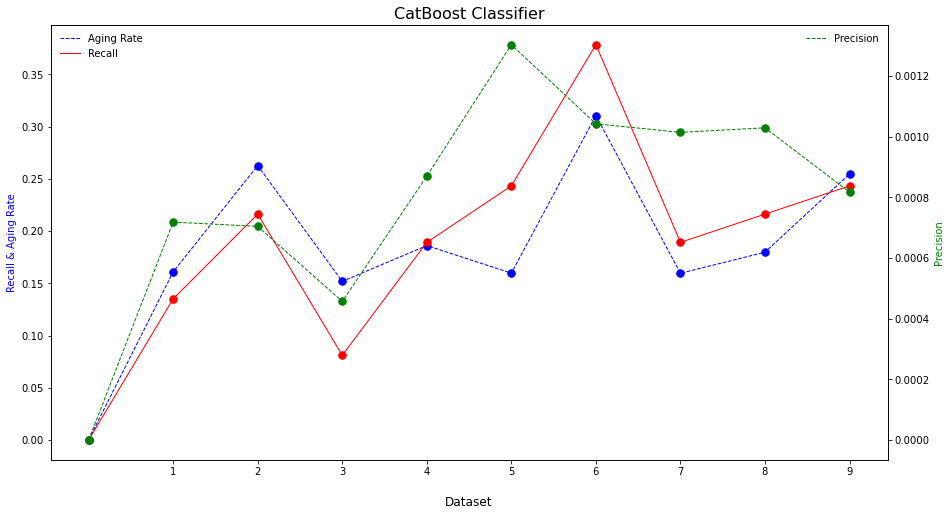

In [8]:
table_setC = runall_CatBoostC(10, run_train_x, run_test_x, run_train_y, run_test_y, best_paramC, cat_feature = [])
line_chart(table_setC, title = 'CatBoost Classifier')

In [9]:
table_setC

,Balance Ratio,Train_OK,Train_NG,TP,FP,FN,TN,Precision,Recall,Aging Rate,Efficiency,Score
dataset 0,479.923077,230843.0,481.0,0.0,9.0,37.0,43197.0,0.000000,0.000000,0.000208,0.000000,0.000000
dataset 1,1.000000,4774.0,4774.0,5.0,6955.0,32.0,36251.0,0.000718,0.135135,0.160951,0.839605,0.000000
dataset 2,1.000000,6276.0,6276.0,8.0,11351.0,29.0,31855.0,0.000704,0.216216,0.262678,0.823122,0.000000
dataset 3,1.000000,5278.0,5278.0,3.0,6563.0,34.0,36643.0,0.000457,0.081081,0.151840,0.533992,0.000000
dataset 4,1.000000,4809.0,4809.0,7.0,8041.0,30.0,35165.0,0.000870,0.189189,0.186111,1.016539,0.132694
dataset 5,1.002501,4810.0,4798.0,9.0,6897.0,28.0,36309.0,0.001303,0.243243,0.159702,1.523106,0.225119
dataset 6,0.758675,4810.0,6340.0,14.0,13415.0,23.0,29791.0,0.001043,0.378378,0.310547,1.218424,0.301491
dataset 7,1.000000,4810.0,4810.0,7.0,6895.0,30.0,36311.0,0.001014,0.189189,0.159610,1.185324,0.147901
dataset 8,1.000000,4810.0,4810.0,8.0,7765.0,29.0,35441.0,0.001029,0.216216,0.179752,1.202861,0.170758
dataset 9,10.000000,4810.0,481.0,9.0,11004.0,28.0,32202.0,0.000817,0.243243,0.254677,0.955105,0.000000


### Regressor

In [ ]:
pr_dict, table_setR = runall_CatBoostR(10, trainset_x, run_test_x, trainset_y, run_test_y, best_paramR, cat_feature = [], 
                                       thres_target = 'Recall', threshold = 0.8)
line_chart(table_setR, title = 'CatBoost Regressor')

In [ ]:
multiple_curve(4, 3, pr_dict, table_setR, target = 'Aging Rate')
multiple_curve(4, 3, pr_dict, table_setR, target = 'Precision')
table_setR

### export

In [10]:
savedate = '20211123'
TPE_multi = False

table_setC['sampler'] = 'multivariate-TPE' if TPE_multi else 'univariate-TPE'
table_setC['model'] = 'CatBoost'
with pd.ExcelWriter(f'{savedate}_Classifier.xlsx', mode = 'a') as writer:
    table_setC.to_excel(writer, sheet_name = 'CatBoost')